In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoConfig
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import re
import seaborn as sns
from collections import defaultdict
import os
from collections import Counter
from adjustText import adjust_text
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from scipy.stats import mannwhitneyu

2025-04-26 11:45:51.065967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_predicted_as_one_filtered = pd.read_csv("df_predicted_as_one_with_attack_support_predictions1.csv", encoding="utf-8")
merged_df =  pd.read_csv("labeled_tweets1.csv", encoding="utf-8")
metadata_df = pd.read_csv("Politicians_metadata.csv", encoding="utf-8")
events = pd.read_csv("Events.csv", encoding="utf-8")
rec_df = pd.read_csv("Politicians_rec_don_countries.csv", encoding="utf-8")
special_rec = pd.read_csv("special_rec.csv", encoding="utf-8")
argument_df = pd.read_csv("country_references.csv", encoding="latin-1")

In [3]:
Counter(df_predicted_as_one_filtered["Attack/Support_Predicted"])

Counter({0: 19959, 1: 18067})

In [4]:
df_predicted_as_one_filtered.to_csv("Official_data.csv", encoding="UTF-8", index= False)

In [5]:
df_predicted_as_one_filtered = df_predicted_as_one_filtered.drop_duplicates(subset=["Tweet Text"], keep="first")

In [6]:
# List of IDs to drop due to fake ID
ids_to_drop = ["baerbockpress"]  

# Drop rows where 'ID' matches any of the specified IDs
df_predicted_as_one_filtered = df_predicted_as_one_filtered[~df_predicted_as_one_filtered["ID"].isin(ids_to_drop)]
merged_df = merged_df[~merged_df["ID"].isin(ids_to_drop)]

In [7]:
df_predicted_as_one_filtered = df_predicted_as_one_filtered.merge(metadata_df[['ID', 'Country']], on='ID', how='left')

In [8]:
# Define the mapping dictionary manually
id_to_name = {
    # Example entries (fill these manually)
    "SergioMassa": "Massa",
    "EmmanuelMacron": "Macron",
    "Bundeskanzler": "Scholz",
    "ArminLaschet": "Laschet",
    "HillaryClinton": "Clinton",
    "CFKArgentina": "Kirchner",
    "sanchezcastejon": "Sanchez",
    "JMilei": "Milei",
    "carlosdmesag": "Mesa",
    "NunezFeijoo": "Feijoo",
    "c_lindner": "Lindner",
    "LuchoXBolivia": "Arce",
    "JoeBiden": "Biden",
    "matteosalvinimi": "Salvini",
    "EnricoLetta": "Letta",
    "Alice_Weidel": "Weidel",
    "luigidimaio": "Di Maio",
    "MLP_officiel": "Le Pen",
    "matteorenzi": "Renzi",
    "SWagenknecht": "Wagenknecht",
    "LuisFerCamachoV": "Camacho",
    "vpecresse": "Pécresse",
    "BernieSanders": "Sanders",
    "GiorgiaMeloni": "Meloni",
    "evoespueblo": "Morales",
    "JLMelenchon": "Melenchon",
    "Santi_ABASCAL": "Abascal",
    "@realDonaldTrump": "Trump",
    "PabloIglesias.json": "Iglesias"
}

# Define a list of datasets to map
datasets = [
    ("df_predicted_as_one_filtered", df_predicted_as_one_filtered),
    ("merged_df", merged_df),
    ("metadata_df", metadata_df),
    ("events", events),
    ("rec_df", rec_df),
    ("special_rec", special_rec),
    ("argument_df", argument_df)
]

# Apply the mapping to the 'ID' columns in each dataset
for dataset_name, dataset in datasets:
    if "ID" in dataset.columns:
        dataset["ID"] = dataset["ID"].map(id_to_name)

In [9]:
# Apply split(",") to all columns except 'Country'
columns_to_split = [col for col in argument_df.columns if col != 'Country']

argument_df[columns_to_split] = argument_df[columns_to_split].applymap(
    lambda x: x.split(",") if isinstance(x, str) else x
)

In [10]:
Counter(df_predicted_as_one_filtered["ID"])

Counter({'Massa': 374,
         'Macron': 2407,
         'Scholz': 602,
         'Laschet': 698,
         'Clinton': 704,
         'Kirchner': 566,
         'Sanchez': 1689,
         'Milei': 573,
         'Mesa': 688,
         'Feijoo': 310,
         'Lindner': 794,
         'Arce': 783,
         'Biden': 738,
         'Salvini': 4247,
         'Letta': 393,
         'Weidel': 555,
         'Di Maio': 308,
         'Iglesias': 1120,
         'Le Pen': 3806,
         'Renzi': 339,
         'Wagenknecht': 630,
         'Camacho': 402,
         'Pécresse': 1614,
         'Sanders': 1624,
         'Meloni': 1811,
         'Morales': 4492,
         'Melenchon': 3429,
         'Abascal': 1563,
         'Trump': 610})

# H1

In [11]:
# Step 1: Get total tweets per author from the original merged_df
total_tweets_per_id = merged_df["ID"].value_counts()

# Step 2: Get the number of IS tweets per author
is_tweets_per_id = df_predicted_as_one_filtered["ID"].value_counts()

# Step 3: Get the number of Support tweets (Attack/Support_Predicted == 0) per author
support_tweets_per_id = df_predicted_as_one_filtered[df_predicted_as_one_filtered["Attack/Support_Predicted"] == 0]["ID"].value_counts()

# Step 4: Get the number of Attack tweets (Attack/Support_Predicted == 1) per author
attack_tweets_per_id = df_predicted_as_one_filtered[df_predicted_as_one_filtered["Attack/Support_Predicted"] == 1]["ID"].value_counts()

# Step 5: Calculate the percentages
percentage_is_tweets_per_id = (is_tweets_per_id / total_tweets_per_id) * 100
percentage_support_tweets_per_id = (support_tweets_per_id / is_tweets_per_id) * 100
percentage_attack_tweets_per_id = (attack_tweets_per_id / is_tweets_per_id) * 100

# Step 6: Create the DataFrame with 'ID' as a column
tweet_summary_df = pd.DataFrame({
    "ID": total_tweets_per_id.index,  # IDs
    "Total_Tweets": total_tweets_per_id.values,
    "IS_Tweets": is_tweets_per_id.reindex(total_tweets_per_id.index, fill_value=0).values,
    "Percentage_IS_Tweets": percentage_is_tweets_per_id.reindex(total_tweets_per_id.index, fill_value=0).values,
    "Support_Tweets": support_tweets_per_id.reindex(total_tweets_per_id.index, fill_value=0).values,
    "Percentage_Support_Tweets": percentage_support_tweets_per_id.reindex(total_tweets_per_id.index, fill_value=0).values,
    "Attack_Tweets": attack_tweets_per_id.reindex(total_tweets_per_id.index, fill_value=0).values,
    "Percentage_Attack_Tweets": percentage_attack_tweets_per_id.reindex(total_tweets_per_id.index, fill_value=0).values
})

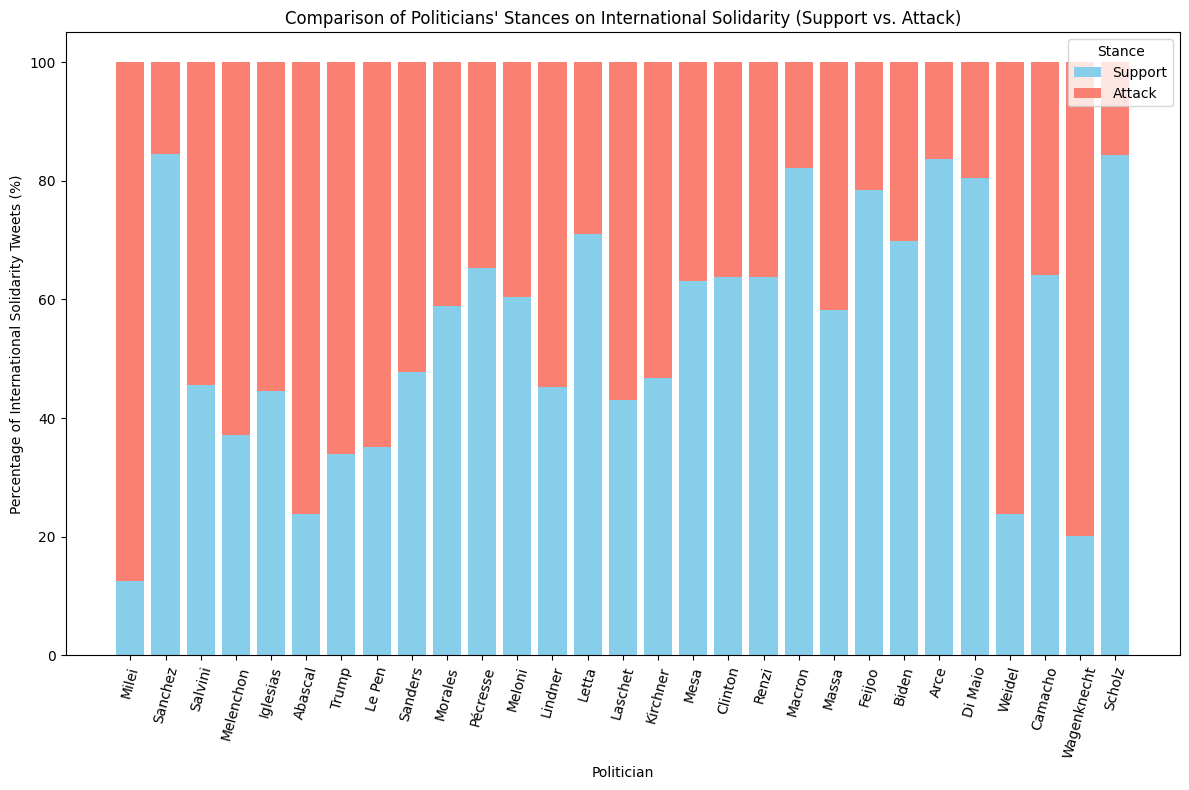

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Use politician IDs as x-ticks instead of numeric indices
x = tweet_summary_df["ID"]

# Create the stacked bar chart for all politicians
ax.bar(x, tweet_summary_df["Percentage_Support_Tweets"], label="Support", color="skyblue")
ax.bar(x, tweet_summary_df["Percentage_Attack_Tweets"], 
       bottom=tweet_summary_df["Percentage_Support_Tweets"], label="Attack", color="salmon")

# Add labels and title
ax.set_xlabel("Politician")
ax.set_ylabel("Percentage of International Solidarity Tweets (%)")
ax.set_title("Comparison of Politicians' Stances on International Solidarity (Support vs. Attack)")
ax.legend(title="Stance")
plt.xticks(rotation=75)
plt.savefig("Politicians stances on International Solidarity (%).pdf", format="pdf", dpi=300)

# Rotate x-axis labels for readability

plt.tight_layout()







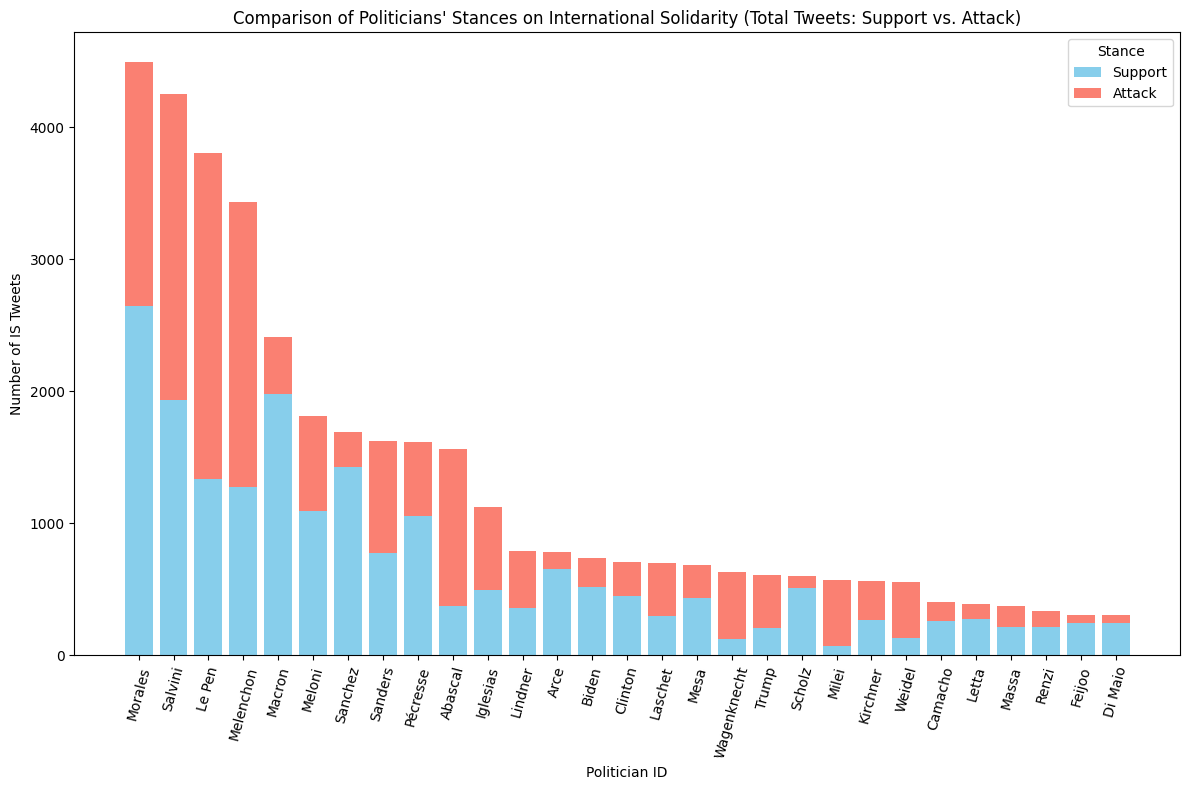

In [13]:

tweet_summary_df = tweet_summary_df.sort_values(by="IS_Tweets", ascending=False)

data_to_plot = tweet_summary_df.set_index("ID")


# Calculate the raw counts of "Support" and "Attack" IS tweets per politician
data_to_plot["Support_Tweet_Count"] = (data_to_plot["IS_Tweets"] * data_to_plot["Percentage_Support_Tweets"] / 100).round()
data_to_plot["Attack_Tweet_Count"] = (data_to_plot["IS_Tweets"] * data_to_plot["Percentage_Attack_Tweets"] / 100).round()

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create the stacked bar chart
ax.bar(data_to_plot.index, data_to_plot["Support_Tweet_Count"], label="Support", color="skyblue")
ax.bar(data_to_plot.index, data_to_plot["Attack_Tweet_Count"], bottom=data_to_plot["Support_Tweet_Count"], label="Attack", color="salmon")

# Add labels and title
ax.set_xlabel("Politician ID")
ax.set_ylabel("Number of IS Tweets")
ax.set_title("Comparison of Politicians' Stances on International Solidarity (Total Tweets: Support vs. Attack)")
ax.legend(title="Stance")

# Rotate x-axis labels for readability
plt.xticks(rotation=75)
plt.tight_layout()

plt.savefig("Politicians stances on International Solidarity with absolute numbers.pdf", format="pdf", dpi=300)
# Show the plot
plt.show()
plt.close()



In [14]:
df_predicted_as_one_filtered = df_predicted_as_one_filtered.merge(
    metadata_df[['ID', 'Populist']], on='ID', how='left'
)

# Drop rows with NaN values in 'Populist' or 'Attack/Support_Predicted'
df_predicted_as_one_filtered = df_predicted_as_one_filtered.dropna(subset=['Populist', 'Attack/Support_Predicted'])

# Define independent variable (Populist) and dependent variable (Attack/Support_Predicted)
X = df_predicted_as_one_filtered[['Populist']]
y = df_predicted_as_one_filtered['Attack/Support_Predicted']

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Perform logistic regression
logit_model = sm.Logit(y, X)
logit_results = logit_model.fit(cov_type='HC0')

# Display regression summary
print(logit_results.summary())

# Compute marginal effects
marginal_effects = logit_results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.657250
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37867
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.05008
Time:                              11:45:58   Log-Likelihood:                -24889.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8931      0.020    -45.395      0.000      

In [15]:
# Calculate group weights
group_counts = df_predicted_as_one_filtered['Populist'].value_counts(normalize=True)
df_predicted_as_one_filtered['weights_pop'] = df_predicted_as_one_filtered['Populist'].map(lambda x: 1 / group_counts[x])

# Define independent and dependent variables
X = sm.add_constant(df_predicted_as_one_filtered[['Populist']])
y = df_predicted_as_one_filtered['Attack/Support_Predicted']

# Perform logistic regression with weights
logit_model = sm.Logit(y, X, freq_weights=df_predicted_as_one_filtered['weights_pop'])
logit_results = logit_model.fit(cov_type='HC0')

# Display regression summary
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.657250
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37867
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.05008
Time:                              11:45:58   Log-Likelihood:                -24889.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8931      0.011    -78.902      0.000      

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [16]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

    feature       VIF
0     const  3.021061
1  Populist  1.000000


In [17]:
#T-Test
populist_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['Populist'] == 1]
non_populist_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['Populist'] == 0]

# Calculate attack percentages for each group
populist_attack_percentage = populist_group['Attack/Support_Predicted'].mean() * 100
non_populist_attack_percentage = non_populist_group['Attack/Support_Predicted'].mean() * 100

# Calculate the difference
attack_diff_pop = populist_attack_percentage - non_populist_attack_percentage

# Perform t-test between the two groups
t_stat, p_value = stats.ttest_ind(
    populist_group['Attack/Support_Predicted'], 
    non_populist_group['Attack/Support_Predicted'], 
    equal_var=False
)

# Display results
print("\nPopulist vs Non-Populist T-Test:")
print(f"Populist Attack Percentage: {populist_attack_percentage:.2f}%")
print(f"Non-Populist Attack Percentage: {non_populist_attack_percentage:.2f}%")
print(f"Difference Attack Percentage: {attack_diff_pop:.2f}%")
print(f"T-Statistic: {t_stat:.3f}")
print(f"P-Value: {p_value:.3e}")


Populist vs Non-Populist T-Test:
Populist Attack Percentage: 56.64%
Non-Populist Attack Percentage: 29.05%
Difference Attack Percentage: 27.59%
T-Statistic: 53.971
P-Value: 0.000e+00


# H2

In [18]:
df_predicted_as_one_filtered["Time"] = df_predicted_as_one_filtered["Time"].str.strip()

# Step 2: Convert to datetime while handling irregular formats
df_predicted_as_one_filtered["date"] = pd.to_datetime(df_predicted_as_one_filtered["Time"].str[:10], errors='coerce')

# Step 3: Drop any rows where 'date' could not be parsed (optional)
df_predicted_as_one_filtered = df_predicted_as_one_filtered.dropna(subset=["date"])

# Step 4: Extract year and month for grouping
df_predicted_as_one_filtered["year_month"] = df_predicted_as_one_filtered["date"].dt.to_period("M").dt.to_timestamp()



In [19]:

# Function to parse individual dates with 'dayfirst=True'
def parse_date(date_str):
    date_str = date_str.strip()  # Remove leading/trailing spaces
    try:
        parsed_date = pd.to_datetime(date_str, dayfirst=True, errors='raise').date()  # Get only the date part
    except ValueError:
        parsed_date = None  # Return None if parsing fails
    return parsed_date

# Split and parse dates in 'in' and 'out' columns
metadata_df['in_dates'] = metadata_df['in'].apply(lambda x: [parse_date(d) for d in x.split(',') if d.strip()])
metadata_df['out_dates'] = metadata_df['out'].apply(lambda x: [parse_date(d) for d in x.split(',') if d.strip()])

# Function to pair each 'in' date with its corresponding 'out' date
def create_government_periods(in_dates, out_dates):
    period_pairs = [(in_date, out_date) for in_date, out_date in zip(in_dates, out_dates) if in_date and out_date]
    return period_pairs

# Apply pairing function
metadata_df['government_periods'] = metadata_df.apply(lambda row: create_government_periods(row['in_dates'], row['out_dates']), axis=1)

# Drop temporary columns
metadata_df = metadata_df.drop(columns=['in_dates', 'out_dates'])

In [20]:
# Initialize a new 'government' column in df_predicted_as_one_filtered to store in/out of government labels
df_predicted_as_one_filtered['government'] = 0  # Default to 0 (out of government)

# Function to check if a tweet's date is within any government period
def is_in_government(tweet_date, government_periods):
    return any(start <= tweet_date <= end for start, end in government_periods)

# Iterate through each politician and update 'government' column in df_predicted_as_one_filtered
for _, row in metadata_df.iterrows():
    politician_id = row['ID']
    government_periods = row['government_periods']
    
    # Select tweets for the current politician
    tweets_for_politician = df_predicted_as_one_filtered['ID'] == politician_id
    
    # Apply the in-government check for each tweet's date in year_month
    df_predicted_as_one_filtered.loc[tweets_for_politician, 'government'] = df_predicted_as_one_filtered.loc[
        tweets_for_politician, 'year_month'
    ].apply(lambda date: 1 if is_in_government(date, government_periods) else 0)

# Optional: Display a summary count of tweets in and out of government
in_gov_count = df_predicted_as_one_filtered['government'].sum()
out_gov_count = len(df_predicted_as_one_filtered) - in_gov_count
print(f"Tweets in government: {in_gov_count}, Tweets out of government: {out_gov_count}")


/tmp/ipykernel_43282/3760732915.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return any(start <= tweet_date <= end for start, end in government_periods)


Tweets in government: 11145, Tweets out of government: 26724


In [21]:
# Ensure 'Attack/Support_Predicted' and 'government' columns are numeric
df_predicted_as_one_filtered['Attack/Support_Predicted'] = pd.to_numeric(df_predicted_as_one_filtered['Attack/Support_Predicted'], errors='coerce')
df_predicted_as_one_filtered['government'] = pd.to_numeric(df_predicted_as_one_filtered['government'], errors='coerce')

# Drop rows with any NaN values in 'Attack/Support_Predicted' or 'government'
df_predicted_as_one_filtered.dropna(subset=['Attack/Support_Predicted', 'government'], inplace=True)

# Define the dependent variable (Attack/Support_Predicted) and independent variable (government)
y = df_predicted_as_one_filtered['Attack/Support_Predicted']
X = df_predicted_as_one_filtered['government']

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit(cov_type='HC0')

# Display regression summary
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.658331
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37867
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.04852
Time:                              11:45:59   Log-Likelihood:                -24930.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2306      0.012     18.726      0.000      

In [22]:
# Ensure 'Attack/Support_Predicted' and 'government' columns are numeric
df_predicted_as_one_filtered['Attack/Support_Predicted'] = pd.to_numeric(df_predicted_as_one_filtered['Attack/Support_Predicted'], errors='coerce')
df_predicted_as_one_filtered['government'] = pd.to_numeric(df_predicted_as_one_filtered['government'], errors='coerce')

# Drop rows with any NaN values in 'Attack/Support_Predicted' or 'government'
df_predicted_as_one_filtered.dropna(subset=['Attack/Support_Predicted', 'government'], inplace=True)

# Calculate weights based on the inverse frequency of 'government' (1 = in-government, 0 = out-government)
group_counts = df_predicted_as_one_filtered['government'].value_counts(normalize=True)
df_predicted_as_one_filtered['weights_gov'] = df_predicted_as_one_filtered['government'].map(lambda x: 1 / group_counts[x])

# Define dependent variable (Attack/Support_Predicted) and independent variable (government)
y = df_predicted_as_one_filtered['Attack/Support_Predicted']
X = df_predicted_as_one_filtered[['government']]

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=df_predicted_as_one_filtered['weights_gov'])
results = model.fit(cov_type='HC0')

# Display regression summary
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.658331
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37867
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.04852
Time:                              11:45:59   Log-Likelihood:                -24930.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2306      0.010     22.291      0.000      

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [23]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      feature       VIF
0       const  1.417041
1  government  1.000000


In [24]:
# Ensure 'Populist' column is numeric
df_predicted_as_one_filtered['Populist'] = pd.to_numeric(df_predicted_as_one_filtered['Populist'], errors='coerce')

# Drop any remaining NaN values in relevant columns
df_predicted_as_one_filtered.dropna(subset=['Attack/Support_Predicted', 'government', 'Populist'], inplace=True)

# Define dependent variable (Attack/Support_Predicted) and create interaction terms for independent variables
y = df_predicted_as_one_filtered['Attack/Support_Predicted']

# Create interaction terms
df_predicted_as_one_filtered['Populist_government'] = df_predicted_as_one_filtered['Populist'] * df_predicted_as_one_filtered['government']

# Define independent variables with interactions
X = df_predicted_as_one_filtered[['Populist', 'government', 'Populist_government']]

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit(cov_type='HC0')

# Display the regression summary
print(results.summary())
# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.640003
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37865
Method:                                 MLE   Df Model:                            3
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.07501
Time:                              11:46:01   Log-Likelihood:                -24236.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4270      0.026 

In [25]:
# Apply weights to variables
df_predicted_as_one_filtered['Populist_weighted'] = (
    df_predicted_as_one_filtered['Populist'] * df_predicted_as_one_filtered['weights_pop']
)
df_predicted_as_one_filtered['government_weighted'] = (
    df_predicted_as_one_filtered['government'] * df_predicted_as_one_filtered['weights_gov']
)

# Create interaction term based on weighted variables
df_predicted_as_one_filtered['Populist_government_weighted'] = (
    df_predicted_as_one_filtered['Populist_weighted'] * df_predicted_as_one_filtered['government_weighted']
)

# Define dependent variable
y = df_predicted_as_one_filtered['Attack/Support_Predicted']

# Define independent variables using weighted columns
X = df_predicted_as_one_filtered[
    ['Populist_weighted', 'government_weighted', 'Populist_government_weighted']
]

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Combine weights for balancing (optional normalization)
df_predicted_as_one_filtered['weights_combined'] = (
    df_predicted_as_one_filtered['weights_pop'] * df_predicted_as_one_filtered['weights_gov']
)

# Normalize combined weights
df_predicted_as_one_filtered['weights_combined'] *= len(df_predicted_as_one_filtered) / df_predicted_as_one_filtered['weights_combined'].sum()

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=df_predicted_as_one_filtered['weights_combined'])
results = model.fit(cov_type='HC0')

# Display regression summary
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.640003
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37865
Method:                                 MLE   Df Model:                            3
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.07501
Time:                              11:46:01   Log-Likelihood:                -24236.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                   

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [26]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                        feature       VIF
0                         const  6.245918
1             Populist_weighted  1.788986
2           government_weighted  2.512442
3  Populist_government_weighted  2.383433


In [27]:
# Calculate the percentage of attack tweets for each combination of Populist and government status
attack_percentage_matrix = (
    df_predicted_as_one_filtered.groupby(['Populist', 'government'])['Attack/Support_Predicted']
    .mean()  # mean will give us the proportion since Attack/Support_Predicted is 0 or 1
    .unstack() * 100  # Unstack to create a matrix with rows and columns, multiply by 100 for percentage
)

# Rename the columns for readability
attack_percentage_matrix.columns = ['Out of Government (%)', 'In Government (%)']
attack_percentage_matrix.index = ['Non-Populist', 'Populist']

# Display the matrix
print("Percentage of Attack Tweets by Populist Status and Government Status:")
print(attack_percentage_matrix)

Percentage of Attack Tweets by Populist Status and Government Status:
              Out of Government (%)  In Government (%)
Non-Populist              39.485403          19.267614
Populist                  60.510140          39.524930


In [28]:
# Step 1: Calculate in-government and out-of-government attack percentages for each politician in government
attack_stats = []

# Filter for IDs that are common to both metadata_df and df_predicted_as_one_filtered
common_ids = set(metadata_df['ID'].unique()).intersection(df_predicted_as_one_filtered['ID'].unique())

# Define a function to process duplicates in Tweet Text column
def handle_duplicates(politician_data):
    # Group by Tweet Text to identify duplicates
    grouped = politician_data.groupby('Tweet Text')
    rows_to_keep = []
    
    for _, group in grouped:
        # If there's at least one "in government" status (1), keep it as 1
        if group['in_government'].max() == 1:
            # Get the first row and set `in_government` to 1
            row = group.iloc[0].copy()
            row['in_government'] = 1
        else:
            # Otherwise, keep `in_government` as 0
            row = group.iloc[0]
        
        # Append the processed row to the list of rows to keep
        rows_to_keep.append(row)
    
    # Return a DataFrame with the unique, processed rows
    return pd.DataFrame(rows_to_keep)

for politician_id in common_ids:
    # Filter data for this politician
    politician_data = df_predicted_as_one_filtered[df_predicted_as_one_filtered['ID'] == politician_id].copy()
    politician_periods = metadata_df[metadata_df['ID'] == politician_id]['government_periods'].values[0]
    
    # Ensure periods are in Timestamp format
    politician_periods = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in politician_periods]
    
    # Classify each tweet as in or out of government
    politician_data['in_government'] = politician_data.apply(
        lambda x: int(any(start <= x['year_month'] <= end for start, end in politician_periods)), axis=1
    )
    
    # Handle duplicates based on Tweet Text
    processed_data = handle_duplicates(politician_data)
    
    # Calculate attack percentages for in-government and out-of-government periods
    in_gov_attack_percentage = processed_data[processed_data['in_government'] == 1]['Attack/Support_Predicted'].mean() * 100
    out_gov_attack_percentage = processed_data[processed_data['in_government'] == 0]['Attack/Support_Predicted'].mean() * 100
    

    
    # Calculate the difference
    attack_diff = in_gov_attack_percentage - out_gov_attack_percentage
    
    # Get populist status
    populist_status = metadata_df[metadata_df['ID'] == politician_id]['Populist'].values[0]
    
    # Append results
    attack_stats.append({
        'ID': politician_id,
        'Populist': populist_status,
        'Attack_Percentage_In_Gov': in_gov_attack_percentage,
        'Attack_Percentage_Out_Gov': out_gov_attack_percentage,
        'Attack_Percentage_Difference': attack_diff
    })

# Convert results to DataFrame
attack_stats_df = pd.DataFrame(attack_stats).dropna(subset=['Attack_Percentage_Difference'])

# Step 3: Perform a t-test to compare the difference in attack percentages between populist and non-populist
populist_diffs = attack_stats_df[attack_stats_df['Populist'] == 1]['Attack_Percentage_Difference']
non_populist_diffs = attack_stats_df[attack_stats_df['Populist'] == 0]['Attack_Percentage_Difference']

t_stat, p_value = stats.ttest_ind(populist_diffs, non_populist_diffs, equal_var=False)


print(attack_stats_df)
# Step 4: Display the results
print("Mean Attack Percentage Difference in government - out governement (Populist):", populist_diffs.mean())
print("Mean Attack Percentage Difference (Non-Populist):", non_populist_diffs.mean())
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


          ID  Populist  Attack_Percentage_In_Gov  Attack_Percentage_Out_Gov  \
1      Massa         0                 22.857143                  43.657817   
2    Camacho         0                 43.421053                  31.200000   
3      Biden         0                 29.545455                  30.427046   
4   Pécresse         0                 30.938776                  46.272494   
6    Lindner         0                 45.364238                  60.569106   
7       Arce         0                 13.819876                  28.057554   
8      Renzi         0                 18.181818                  39.788732   
9    Sanchez         0                  6.422925                  29.246677   
11  Iglesias         1                 44.274809                  56.926188   
12     Milei         1                 42.857143                  89.130435   
16    Macron         0                 14.735867                  44.578313   
17     Trump         1                 47.596154    

In [29]:
# Step 1: Calculate in-government and out-of-government attack percentages for each politician in government
attack_stats = []

# Define a function to process duplicates in Tweet Text column
def handle_duplicates(politician_data):
    # Group by Tweet Text to identify duplicates
    grouped = politician_data.groupby('Tweet Text')
    rows_to_keep = []
    
    for _, group in grouped:
        # If there's at least one "in government" status (1), keep it as 1
        if group['in_government'].max() == 1:
            # Get the first row and set `in_government` to 1
            row = group.iloc[0].copy()
            row['in_government'] = 1
        else:
            # Otherwise, keep `in_government` as 0
            row = group.iloc[0]
        
        # Append the processed row to the list of rows to keep
        rows_to_keep.append(row)
    
    # Return a DataFrame with the unique, processed rows
    return pd.DataFrame(rows_to_keep)

for politician_id in common_ids:
    # Filter data for this politician
    politician_data = df_predicted_as_one_filtered[df_predicted_as_one_filtered['ID'] == politician_id].copy()
    politician_periods = metadata_df[metadata_df['ID'] == politician_id]['government_periods'].values[0]
    
    # Ensure periods are in Timestamp format
    politician_periods = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in politician_periods]
    
    # Classify each tweet as in or out of government
    politician_data['in_government'] = politician_data.apply(
        lambda x: int(any(start <= x['year_month'] <= end for start, end in politician_periods)), axis=1
    )
    
    # Handle duplicates based on Tweet Text
    processed_data = handle_duplicates(politician_data)
    
    # Separate tweets into in-government and out-of-government periods for attack analysis
    in_gov_attacks = processed_data[processed_data['in_government'] == 1]['Attack/Support_Predicted']
    out_gov_attacks = processed_data[processed_data['in_government'] == 0]['Attack/Support_Predicted']
    
    # Calculate the difference if both periods have data
    if not in_gov_attacks.empty and not out_gov_attacks.empty:
        t_stat, p_value = stats.ttest_ind(in_gov_attacks, out_gov_attacks, equal_var=False)
        #print("ID:", politician_id, "T-statistic:", t_stat, "P-value:", p_value)
        
        attack_diff = in_gov_attacks.mean() * 100 - out_gov_attacks.mean() * 100
        populist_status = metadata_df[metadata_df['ID'] == politician_id]['Populist'].values[0]
        
        # Append results
        attack_stats.append({
            'ID': politician_id,
            'Populist': populist_status,
            'Attack_Percentage_In_Gov': in_gov_attacks.mean() * 100,
            'Attack_Percentage_Out_Gov': out_gov_attacks.mean() * 100,
            'Attack_Percentage_Difference': attack_diff,
            'T-statistic': t_stat,
            'P-value': p_value
        })

# Convert results to DataFrame
attack_stats_df = pd.DataFrame(attack_stats).dropna(subset=['Attack_Percentage_Difference'])


# Display summary statistics
significant_tests = attack_stats_df[attack_stats_df['P-value'] < 0.05]
print("\nPoliticians with a statistically significant difference in attack percentage when in government:")
significant_tests


Politicians with a statistically significant difference in attack percentage when in government:


,ID,Populist,Attack_Percentage_In_Gov,Attack_Percentage_Out_Gov,Attack_Percentage_Difference,T-statistic,P-value
0,Massa,0,22.857143,43.657817,-20.800674,-2.704851,9.673434e-03
1,Camacho,0,43.421053,31.200000,12.221053,2.449587,1.486980e-02
3,Pécresse,0,30.938776,46.272494,-15.333718,-5.370135,1.117761e-07
4,Lindner,0,45.364238,60.569106,-15.204867,-4.201202,3.040118e-05
5,Arce,0,13.819876,28.057554,-14.237678,-3.507277,5.756478e-04
6,Renzi,0,18.181818,39.788732,-21.606914,-3.600468,5.177977e-04
7,Sanchez,0,6.422925,29.246677,-22.823752,-11.937355,1.098309e-30
8,Iglesias,1,44.274809,56.926188,-12.651379,-2.730980,6.997785e-03
9,Milei,1,42.857143,89.130435,-46.273292,-4.151996,4.684094e-04
10,Macron,0,14.735867,44.578313,-29.842447,-9.190076,9.511119e-18


In [30]:
# Convert 'year_month' in tweet data to datetime format
df_predicted_as_one_filtered["year_month"] = pd.to_datetime(df_predicted_as_one_filtered["year_month"], format="%Y-%m")

# Group data by 'ID', 'year_month', and 'Attack/Support_Predicted' (support: 0, attack: 1)
monthly_counts = df_predicted_as_one_filtered.groupby(["ID", "year_month", "Attack/Support_Predicted"]).size().unstack(fill_value=0).reset_index()
monthly_counts.columns = ["ID", "Year_Month", "Support", "Attack"]

# Directory to save the plots
output_directory = "leader_attack_support_plots"
os.makedirs(output_directory, exist_ok=True)

# Iterate over each unique politician ID
for politician_id in monthly_counts["ID"].unique():
    # Filter data for the current politician
    data = monthly_counts[monthly_counts["ID"] == politician_id]
    
    # Retrieve government periods for the current politician
    government_periods = metadata_df.loc[metadata_df["ID"] == politician_id, "government_periods"].values
    government_periods = government_periods[0] if len(government_periods) > 0 else []

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data["Year_Month"], data["Support"], label="Support", marker="o", color="skyblue")
    ax.plot(data["Year_Month"], data["Attack"], label="Attack", marker="o", color="salmon")

    # Add shaded regions for government periods
    for start, end in government_periods:
        if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
            ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)

    # Set x-axis to only show every 3rd month from available data
    x_labels = data["Year_Month"].tolist()
    ax.set_xticks(x_labels[::3])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=75)

    # Add labels, title, and legend
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Number of Tweets")
    ax.set_title(f"Monthly Attack vs. Support Tweets for leader: {politician_id}")
    ax.legend(title="Stance", loc="upper left", fontsize=8)

    # Adjust layout
    plt.tight_layout()

    # Save the plot for the current politician
    plot_path = os.path.join(output_directory, f"{politician_id}_attack_support_plot.pdf")
    plt.savefig(plot_path, format="pdf", dpi=300, bbox_inches="tight")  # Ensure everything is included
    plt.close()

    print(f"Saved plot for {politician_id} at: {plot_path}")

/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Abascal at: leader_attack_support_plots/Abascal_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Arce at: leader_attack_support_plots/Arce_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Biden at: leader_attack_support_plots/Biden_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Camacho at: leader_attack_support_plots/Camacho_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Clinton at: leader_attack_support_plots/Clinton_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Di Maio at: leader_attack_support_plots/Di Maio_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Feijoo at: leader_attack_support_plots/Feijoo_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Iglesias at: leader_attack_support_plots/Iglesias_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Kirchner at: leader_attack_support_plots/Kirchner_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Laschet at: leader_attack_support_plots/Laschet_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Le Pen at: leader_attack_support_plots/Le Pen_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Letta at: leader_attack_support_plots/Letta_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Lindner at: leader_attack_support_plots/Lindner_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Macron at: leader_attack_support_plots/Macron_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Massa at: leader_attack_support_plots/Massa_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Melenchon at: leader_attack_support_plots/Melenchon_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Meloni at: leader_attack_support_plots/Meloni_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Mesa at: leader_attack_support_plots/Mesa_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Milei at: leader_attack_support_plots/Milei_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Morales at: leader_attack_support_plots/Morales_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Pécresse at: leader_attack_support_plots/Pécresse_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Renzi at: leader_attack_support_plots/Renzi_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Salvini at: leader_attack_support_plots/Salvini_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)


Saved plot for Sanchez at: leader_attack_support_plots/Sanchez_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Sanders at: leader_attack_support_plots/Sanders_attack_support_plot.pdf
Saved plot for Scholz at: leader_attack_support_plots/Scholz_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/3721187364.py:29: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="grey", alpha=0.3)
/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd

Saved plot for Trump at: leader_attack_support_plots/Trump_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Wagenknecht at: leader_attack_support_plots/Wagenknecht_attack_support_plot.pdf


/tmp/ipykernel_43282/3721187364.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Weidel at: leader_attack_support_plots/Weidel_attack_support_plot.pdf


In [31]:
# Convert 'year_month' in tweet data and 'start'/'end' in event data to datetime format
df_predicted_as_one_filtered["year_month"] = pd.to_datetime(df_predicted_as_one_filtered["year_month"], format="%Y-%m")
events["start"] = pd.to_datetime(events["start"], dayfirst=True, errors="coerce")
events["end"] = pd.to_datetime(events["end"], dayfirst=True, errors="coerce")

# Group data by 'ID', 'year_month', and 'Attack/Support_Predicted' (support: 0, attack: 1)
monthly_counts = df_predicted_as_one_filtered.groupby(["ID", "year_month", "Attack/Support_Predicted"]).size().unstack(fill_value=0).reset_index()
monthly_counts.columns = ["ID", "Year_Month", "Support", "Attack"]

# Directory to save the plots
output_directory = "leader_attack_support_plots"
os.makedirs(output_directory, exist_ok=True)

# Iterate over each unique politician ID
for politician_id in monthly_counts["ID"].unique():
    # Filter data for the current politician
    data = monthly_counts[monthly_counts["ID"] == politician_id]
    
    # Retrieve government periods for the current politician
    government_periods = metadata_df.loc[metadata_df["ID"] == politician_id, "government_periods"].values
    government_periods = government_periods[0] if len(government_periods) > 0 else []
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data["Year_Month"], data["Support"], label="Support", marker="o", color="skyblue")
    ax.plot(data["Year_Month"], data["Attack"], label="Attack", marker="o", color="salmon")
    
    # Add shaded regions for government periods
    for start, end in government_periods:
        if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
            ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)
    
    # Set x-axis to only show every 3rd month from available data
    x_labels = data["Year_Month"].tolist()
    ax.set_xticks(x_labels[::3])
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=75)

    # Initialize a dictionary to keep track of event labels for the legend
    event_labels = {}

    # Add indexed green/red lines for events within the date range
    for idx, event in events.iterrows():
        event_name = event["event"]
        event_start = event["start"]
        event_end = event["end"]
        
        # Plot start of the event (green) if within timeline, add index label
        if data["Year_Month"].iloc[0] <= event_start <= data["Year_Month"].iloc[-1]:
            ax.axvline(event_start, color="green", linestyle="--", linewidth=1)
            ax.text(event_start, ax.get_ylim()[1] * 0.95, f"{idx+1}", ha="center", va="bottom", color="green")
            
            # Add legend entry for start and end, handle case when they are the same
            if event_start == event_end:
                event_labels[f"{idx+1}"] = f"{event_name} (start - end)"
            else:
                event_labels[f"{idx+1}"] = f"{event_name} (start)"
        
        # Plot end of the event (red) if within timeline and different from start
        if event_start != event_end and data["Year_Month"].iloc[0] <= event_end <= data["Year_Month"].iloc[-1]:
            ax.axvline(event_end, color="red", linestyle="--", linewidth=1)
            ax.text(event_end, ax.get_ylim()[1] * 0.95, f"{idx+1}", ha="center", va="bottom", color="red")
            event_labels[f"{idx+1}"] = f"{event_name}"

    # Add labels, title, and legend
    ax.set_xlabel("Year-Month")
    ax.set_ylabel("Number of Tweets")
    ax.set_title(f"Monthly Attack vs. Support Tweets for leader: {politician_id}")
    ax.legend(title="Stance", loc="upper left", bbox_to_anchor=(0.02, 0.98), fontsize=8)

    # Add a legend for events with indexes below the plot
    event_legend = [f"{idx}: {desc}" for idx, desc in event_labels.items()]
    plt.figtext(0.02, -0.15, "\n".join(event_legend), horizontalalignment='left', fontsize=8, color="black", wrap=True)

    # Adjust layout
    plt.tight_layout()

    # Save the plot for the current politician
    plot_path = os.path.join(output_directory, f"{politician_id}_attack_support_plot.pdf")
    plt.savefig(plot_path, format="pdf", dpi=300, bbox_inches="tight")  # Ensure everything is included
    plt.close()

    print(f"Saved plot for {politician_id} at: {plot_path}")


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Abascal at: leader_attack_support_plots/Abascal_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Arce at: leader_attack_support_plots/Arce_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Biden at: leader_attack_support_plots/Biden_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Camacho at: leader_attack_support_plots/Camacho_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Clinton at: leader_attack_support_plots/Clinton_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Di Maio at: leader_attack_support_plots/Di Maio_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Feijoo at: leader_attack_support_plots/Feijoo_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Iglesias at: leader_attack_support_plots/Iglesias_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Kirchner at: leader_attack_support_plots/Kirchner_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Laschet at: leader_attack_support_plots/Laschet_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Le Pen at: leader_attack_support_plots/Le Pen_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Letta at: leader_attack_support_plots/Letta_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Lindner at: leader_attack_support_plots/Lindner_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Macron at: leader_attack_support_plots/Macron_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Massa at: leader_attack_support_plots/Massa_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Melenchon at: leader_attack_support_plots/Melenchon_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Meloni at: leader_attack_support_plots/Meloni_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Mesa at: leader_attack_support_plots/Mesa_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Milei at: leader_attack_support_plots/Milei_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Morales at: leader_attack_support_plots/Morales_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Pécresse at: leader_attack_support_plots/Pécresse_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Renzi at: leader_attack_support_plots/Renzi_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Salvini at: leader_attack_support_plots/Salvini_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Sanchez at: leader_attack_support_plots/Sanchez_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Sanders at: leader_attack_support_plots/Sanders_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Scholz at: leader_attack_support_plots/Scholz_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:
/tmp/ipykernel_43282/875637941.py:31: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ax.axvspan(max(start, data["Year_Month"].iloc[0]), min(end, data["Year_Month"].iloc[-1]), color="lightgrey", alpha=0.3)


Saved plot for Trump at: leader_attack_support_plots/Trump_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Wagenknecht at: leader_attack_support_plots/Wagenknecht_attack_support_plot.pdf


/tmp/ipykernel_43282/875637941.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if start <= data["Year_Month"].iloc[-1] and end >= data["Year_Month"].iloc[0]:


Saved plot for Weidel at: leader_attack_support_plots/Weidel_attack_support_plot.pdf


# H3

In [32]:
# Step 1: Split 'period' into 'start_date' and 'end_date' in 'special_rec'
special_rec[['start_date', 'end_date']] = special_rec['period'].str.split(', ', expand=True)
special_rec['start_date'] = pd.to_datetime(special_rec['start_date'], format='%d-%m-%Y')
special_rec['end_date'] = pd.to_datetime(special_rec['end_date'], format='%d-%m-%Y')

# Step 2: Define a function to check if a tweet is within the period
def get_rec_don_value(row, special_rec):
    # Filter for matching ID
    matching_records = special_rec[special_rec['ID'] == row['ID']]
    for _, record in matching_records.iterrows():
        start_date = record['start_date']
        end_date = record['end_date']
        # Check if the tweet's date is within the period
        if start_date <= row['year_month'] <= end_date:
            return record['rec/don']  # Return the 'rec/don' value if it matches
    return None  # Return None if no matching period is found

# Step 3: Apply the function to df_predicted_as_one_filtered to create the 'rec/don' column
df_predicted_as_one_filtered['rec/don'] = df_predicted_as_one_filtered.apply(
    lambda row: get_rec_don_value(row, special_rec), axis=1
)

In [33]:
# Step 1: Count non-NaN values in 'rec/don' column of df_predicted_as_one_filtered
non_nan_count = df_predicted_as_one_filtered['rec/don'].notna().sum()
print(f"Number of non-NaN entries in 'rec/don': {non_nan_count}")

# Step 2: Create a DataFrame with ['ID', 'rec/don'] from rec_df
rec_df_subset = rec_df[['ID', 'rec/don']].dropna()

# Step 3: Update NaN values in 'rec/don' column of df_predicted_as_one_filtered based on matching ID in rec_df
df_predicted_as_one_filtered = df_predicted_as_one_filtered.merge(
    rec_df_subset, 
    on='ID', 
    how='left', 
    suffixes=('', '_rec_df')
)

# Step 4: Fill NaN values in 'rec/don' with 'rec/don_rec_df' values from rec_df
df_predicted_as_one_filtered['rec/don'].fillna(df_predicted_as_one_filtered['rec/don_rec_df'], inplace=True)

# Step 5: Drop the temporary 'rec/don_rec_df' column
df_predicted_as_one_filtered.drop(columns=['rec/don_rec_df'], inplace=True)

# Optional: Display the count of non-NaN values after filling
updated_non_nan_count = df_predicted_as_one_filtered['rec/don'].notna().sum()
print(f"Number of non-NaN entries in 'rec/don' after filling: {updated_non_nan_count}")

Number of non-NaN entries in 'rec/don': 3188
Number of non-NaN entries in 'rec/don' after filling: 38435


In [34]:
df_predicted_as_one_filtered['rec/don'] = df_predicted_as_one_filtered['rec/don'].astype('category').cat.codes
df_predicted_as_one_filtered = df_predicted_as_one_filtered.drop_duplicates(subset=["Tweet Text"], keep="first")
# Set `y` as the binary variable `Attack/Support_Predicted`
y = df_predicted_as_one_filtered['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Set `X` as the independent variable(s), including `rec/don` as a predictor
X = df_predicted_as_one_filtered[['rec/don']]
X = sm.add_constant(X)  # Adds an intercept to the model

# Step 2: Perform logistic regression
model = sm.Logit(y, X)
result = model.fit(cov_type='HC0')

# Step 3: Display the regression summary
print(result.summary())
# Compute marginal effects
marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.687868
         Iterations 4
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37867
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                0.005832
Time:                              11:47:04   Log-Likelihood:                -26049.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                 1.989e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3147      0.016    -19.506      0.000      

In [35]:
# Calculate weights for `rec/don` based on inverse frequency
recdon_counts = df_predicted_as_one_filtered['rec/don'].value_counts(normalize=True)
df_predicted_as_one_filtered['weights_recdon'] = df_predicted_as_one_filtered['rec/don'].map(lambda x: 1 / recdon_counts[x])

# Set `y` as the binary dependent variable `Attack/Support_Predicted`
y = df_predicted_as_one_filtered['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Set `X` as the independent variable(s), including `rec/don` as a predictor
X = df_predicted_as_one_filtered[['rec/don']]
X = sm.add_constant(X)  # Adds an intercept to the model

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=df_predicted_as_one_filtered['weights_recdon'])
result = model.fit(cov_type='HC0')

# Display the regression summary
print(result.summary())

# Compute marginal effects
marginal_effects = result.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.687868
         Iterations 4
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37867
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                0.005832
Time:                              11:47:04   Log-Likelihood:                -26049.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                 1.989e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3147      0.010    -30.249      0.000      

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [36]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

   feature       VIF
0    const  2.404686
1  rec/don  1.000000


In [37]:
# Step 1: Calculate attack percentages for 'rec' and 'don' groups
rec_don_stats = []

# Separate the data into 'rec' and 'don' groups
rec_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['rec/don'] == 0]
don_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['rec/don'] == 1]

# Calculate attack percentages for each group
rec_attack_percentage = rec_group['Attack/Support_Predicted'].mean() * 100
don_attack_percentage = don_group['Attack/Support_Predicted'].mean() * 100

# Calculate the difference
attack_diff_rec_don = don_attack_percentage - rec_attack_percentage

# Perform t-test between the two groups
t_stat, p_value = stats.ttest_ind(don_group['Attack/Support_Predicted'], rec_group['Attack/Support_Predicted'], equal_var=False)

# Append results to rec_don_stats
rec_don_stats.append({
    'Group': 'rec vs don',
    'Attack_Percentage_Rec': rec_attack_percentage,
    'Attack_Percentage_Don': don_attack_percentage,
    'Attack_Percentage_Difference': attack_diff_rec_don,
    'T-statistic': t_stat,
    'P-value': p_value
})

# Convert results to DataFrame
rec_don_stats_df = pd.DataFrame(rec_don_stats)

# Display summary statistics
print("\nAttack Percentage Difference for rec vs don:")
print(rec_don_stats_df)



Attack Percentage Difference for rec vs don:
        Group  Attack_Percentage_Rec  Attack_Percentage_Don  \
0  rec vs don              42.195834              51.286108   

   Attack_Percentage_Difference  T-statistic       P-value  
0                      9.090274    17.564712  9.215832e-69  


In [38]:
# Filter the dataset for populist = 1
populist_df = df_predicted_as_one_filtered[df_predicted_as_one_filtered['Populist'] == 1]

# Convert 'rec/don' to categorical codes
populist_df['rec/don'] = populist_df['rec/don'].astype('category').cat.codes

# Drop duplicate tweets
populist_df = populist_df.drop_duplicates(subset=["Tweet Text"], keep="first")

# Set `y` as the binary variable `Attack/Support_Predicted`
y = populist_df['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Set `X` as the independent variable(s), including `rec/don` as a predictor
X = populist_df[['rec/don']]
X = sm.add_constant(X)  # Adds an intercept to the model

# Perform logistic regression
model = sm.Logit(y, X)
result = model.fit(cov_type='HC0')

# Display the regression summary
print(result.summary())

# Compute marginal effects
marginal_effects = result.get_margeff()
print(marginal_effects.summary())


/tmp/ipykernel_43282/742174591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  populist_df['rec/don'] = populist_df['rec/don'].astype('category').cat.codes


Optimization terminated successfully.
         Current function value: 0.676532
         Iterations 4
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                25334
Model:                                Logit   Df Residuals:                    25332
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.01136
Time:                              11:47:04   Log-Likelihood:                -17139.
converged:                             True   LL-Null:                       -17336.
Covariance Type:                        HC0   LLR p-value:                 1.213e-87
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0131      0.019     -0.691      0.489      

In [39]:
# Calculate weights for `rec/don` based on inverse frequency
recdon_counts = populist_df['rec/don'].value_counts(normalize=True)
populist_df['weight_recdon'] = populist_df['rec/don'].map(lambda x: 1 / recdon_counts[x])

# Set `y` as the binary dependent variable `Attack/Support_Predicted`
y = populist_df['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Set `X` as the independent variable(s), including `rec/don` as a predictor
X = populist_df[['rec/don']]
X = sm.add_constant(X)  # Adds an intercept to the model

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=populist_df['weight_recdon'])
result = model.fit(cov_type='HC0')

# Display the regression summary
print(result.summary())

# Compute marginal effects
marginal_effects = result.get_margeff()
print(marginal_effects.summary())

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.676532
         Iterations 4
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                25334
Model:                                Logit   Df Residuals:                    25332
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.01136
Time:                              11:47:05   Log-Likelihood:                -17139.
converged:                             True   LL-Null:                       -17336.
Covariance Type:                        HC0   LLR p-value:                 1.213e-87
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0131      0.013     -1.042      0.298      

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [40]:
# Ensure 'Populist' column is numeric
df_predicted_as_one_filtered['Populist'] = pd.to_numeric(df_predicted_as_one_filtered['Populist'], errors='coerce')

# Drop any remaining NaN values in relevant columns
df_predicted_as_one_filtered.dropna(subset=['Attack/Support_Predicted', 'rec/don', 'Populist'], inplace=True)

# Define dependent variable (Attack/Support_Predicted) and create interaction terms for independent variables
y = df_predicted_as_one_filtered['Attack/Support_Predicted']

# Create interaction terms
df_predicted_as_one_filtered['rec/don_populist'] = df_predicted_as_one_filtered['Populist'] * df_predicted_as_one_filtered['rec/don']

# Define independent variables with interactions
X = df_predicted_as_one_filtered[['Populist', 'rec/don', 'rec/don_populist']]

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit(cov_type='HC0')

# Display the regression summary
print(results.summary())
# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.650868
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37865
Method:                                 MLE   Df Model:                            3
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.05931
Time:                              11:47:05   Log-Likelihood:                -24648.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1501      0.035    -33.31

In [41]:

df_predicted_as_one_filtered['weights_combined'] = df_predicted_as_one_filtered['weights_recdon'] * df_predicted_as_one_filtered['weights_pop']

# Optional: Normalize weights to ensure they sum to the number of observations
df_predicted_as_one_filtered['weights_combined'] *= (
    len(df_predicted_as_one_filtered) / df_predicted_as_one_filtered['weights_combined'].sum()
)

# Define dependent variable (Attack/Support_Predicted)
y = df_predicted_as_one_filtered['Attack/Support_Predicted']

# Create interaction terms
df_predicted_as_one_filtered['rec/don_populist'] = df_predicted_as_one_filtered['Populist'] * df_predicted_as_one_filtered['rec/don']

# Define independent variables with interactions
X = df_predicted_as_one_filtered[['Populist', 'rec/don', 'rec/don_populist']]
X = sm.add_constant(X)  # Add an intercept to the model

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=df_predicted_as_one_filtered['weights_combined'])
results = model.fit(cov_type='HC0')

# Display regression summary
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.650868
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37865
Method:                                 MLE   Df Model:                            3
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.05931
Time:                              11:47:05   Log-Likelihood:                -24648.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1501      0.026    -44.99

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [42]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            feature       VIF
0             const  8.241349
1          Populist  2.576870
2           rec/don  3.160564
3  rec/don_populist  4.468560


In [43]:
attack_percentage_df = (
    df_predicted_as_one_filtered.groupby(['Populist', 'rec/don'])['Attack/Support_Predicted']
    .mean()  # Proportion since Attack/Support_Predicted is 0 or 1
    .reset_index()  # Convert the matrix into a DataFrame
)

# Convert proportions to percentages
attack_percentage_df['Attack_Percentage'] = attack_percentage_df['Attack/Support_Predicted'] * 100

# Renaming columns for clarity
attack_percentage_df = attack_percentage_df.rename(columns={
    'Populist': 'Populist Status',
    'rec/don': 'Recipient/Donor',
    'Attack_Percentage': 'Attack Percentage (%)'
})

# Displaying the resulting DataFrame
print(attack_percentage_df)

   Populist Status  Recipient/Donor  Attack/Support_Predicted  \
0                0                0                  0.240479   
1                0                1                  0.319395   
2                1                0                  0.496727   
3                1                1                  0.621183   

   Attack Percentage (%)  
0              24.047878  
1              31.939547  
2              49.672734  
3              62.118327  


In [44]:
# Step 1: Pivot the DataFrame to calculate differences between Donor (1) and Recipient (0)
pivot_df = attack_percentage_df.pivot(index='Populist Status', 
                                      columns='Recipient/Donor', 
                                      values='Attack Percentage (%)').reset_index()

# Rename columns for clarity
pivot_df = pivot_df.rename(columns={0: 'Recipient (%)', 1: 'Donor (%)'})

# Add a column for Attack Percentage Difference (Donor - Recipient)
pivot_df['Attack_Percentage_Difference'] = pivot_df['Donor (%)'] - pivot_df['Recipient (%)']

# Step 2: Separate differences for Populist and Non-Populist groups
populist_diffs = pivot_df.loc[pivot_df['Populist Status'] == 1, 'Attack_Percentage_Difference']
non_populist_diffs = pivot_df.loc[pivot_df['Populist Status'] == 0, 'Attack_Percentage_Difference']

u_stat, p_value = mannwhitneyu(populist_diffs, non_populist_diffs, alternative='two-sided')



print("Populist vs. Non-Populist Attack Percentage Differences:")
print(f"\nMean Attack Percentage Difference (Populist): {populist_diffs.mean():.2f}")
print(f"Mean Attack Percentage Difference (Non-Populist): {non_populist_diffs.mean():.2f}")
print(f"Mann-Whitney U Test Statistic: {u_stat}")
print(f"P-Value: {p_value}")


Populist vs. Non-Populist Attack Percentage Differences:

Mean Attack Percentage Difference (Populist): 12.45
Mean Attack Percentage Difference (Non-Populist): 7.89
Mann-Whitney U Test Statistic: 1.0
P-Value: 1.0


# H4

In [45]:
df_predicted_as_one_filtered = df_predicted_as_one_filtered.merge(
    metadata_df[['ID', 'orientation']], 
    on='ID', 
    how='left'
)

In [46]:
# One-hot encode the orientation variable to include each class level as a separate predictor
orientation_dummies = pd.get_dummies(df_predicted_as_one_filtered['orientation'], prefix='orientation', drop_first=True)
print(orientation_dummies.columns)
X = sm.add_constant(orientation_dummies)  # Add intercept

# Define the dependent variable
y = df_predicted_as_one_filtered['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit(cov_type='HC0')

# Display the results
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Index(['orientation_Center right', 'orientation_Left', 'orientation_Right'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.659672
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37865
Method:                                 MLE   Df Model:                            3
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.04658
Time:                              11:47:05   Log-Likelihood:                -24981.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [47]:
# Calculate weights for `orientation` based on inverse frequency
orientation_counts = df_predicted_as_one_filtered['orientation'].value_counts(normalize=True)
df_predicted_as_one_filtered['weight_orientation'] = df_predicted_as_one_filtered['orientation'].map(lambda x: 1 / orientation_counts[x])

# Normalize weights to ensure they sum to the total number of observations
df_predicted_as_one_filtered['weight_orientation'] *= (
    len(df_predicted_as_one_filtered) / df_predicted_as_one_filtered['weight_orientation'].sum()
)

# Add intercept to the design matrix
X = sm.add_constant(orientation_dummies)

# Define the dependent variable
y = df_predicted_as_one_filtered['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=df_predicted_as_one_filtered['weight_orientation'])
results = model.fit(cov_type='HC0')

# Display the regression summary
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.659672
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37865
Method:                                 MLE   Df Model:                            3
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.04658
Time:                              11:47:05   Log-Likelihood:                -24981.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                        HC0   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.0

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [48]:
group_stats = []

# Update filtering criteria based on actual values
cr_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['orientation'] == "Center right"]
cl_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['orientation'] == "Center left"]
l_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['orientation'] == "Left"]
r_group = df_predicted_as_one_filtered[df_predicted_as_one_filtered['orientation'] == "Right"]

# Check groups
groups = [
    ('Center right', cr_group),
    ('Center left', cl_group),
    ('Left', l_group),
    ('Right', r_group)
]

for name, group in groups:
    print(f"{name} Group Size: {len(group)}")
    print(f"{name} Group Variance: {group['Attack/Support_Predicted'].var()}")

# Calculate attack percentages and perform pairwise t-tests
for i, (group1_name, group1_data) in enumerate(groups):
    group1_attack_percentage = group1_data['Attack/Support_Predicted'].mean() * 100
    for j, (group2_name, group2_data) in enumerate(groups):
        if i < j:  # Avoid duplicate and self-comparison
            group2_attack_percentage = group2_data['Attack/Support_Predicted'].mean() * 100
            
            # Calculate attack percentage difference
            attack_diff = group2_attack_percentage - group1_attack_percentage
            
            # Perform t-test
            t_stat, p_value = stats.ttest_ind(
                group1_data['Attack/Support_Predicted'],
                group2_data['Attack/Support_Predicted'],
                equal_var=False
            )
            
            # Append results to the list
            group_stats.append({
                'Group1': group1_name,
                'Group2': group2_name,
                'Attack_Percentage_Group1': group1_attack_percentage,
                'Attack_Percentage_Group2': group2_attack_percentage,
                'Attack_Percentage_Difference': attack_diff,
                'T-statistic': t_stat,
                'P-value': p_value
            })

# Convert results to DataFrame
group_stats_df = pd.DataFrame(group_stats)

# Display the results
print("\nAttack Percentage Differences and T-Tests Between Groups:")
print(group_stats_df)

Center right Group Size: 5823
Center right Group Variance: 0.2190826566819775
Center left Group Size: 5527
Center left Group Variance: 0.1962756319927424
Left Group Size: 12952
Left Group Variance: 0.2500177773695302
Right Group Size: 13567
Right Group Variance: 0.23970869164508526

Attack Percentage Differences and T-Tests Between Groups:
         Group1       Group2  Attack_Percentage_Group1  \
0  Center right  Center left                 32.405976   
1  Center right         Left                 32.405976   
2  Center right        Right                 32.405976   
3   Center left         Left                 26.813823   
4   Center left        Right                 26.813823   
5          Left        Right                 49.876467   

   Attack_Percentage_Group2  Attack_Percentage_Difference  T-statistic  \
0                 26.813823                     -5.592153     6.539040   
1                 49.876467                     17.470491   -23.155045   
2                 60.153313  

In [49]:

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                    feature       VIF
0                     const  6.851637
1  orientation_Center right  1.737786
2          orientation_Left  2.199890
3         orientation_Right  2.217000


In [50]:

# Filter for populist politicians only
populist_data = df_predicted_as_one_filtered[df_predicted_as_one_filtered['Populist'] == 1]

print(set(populist_data['orientation']))
# One-hot encode the 'orientation' variable to include each class level as a separate predictor
orientation_dummies = pd.get_dummies(populist_data['orientation'], prefix='orientation', drop_first=True)
print(orientation_dummies.columns)
X = sm.add_constant(orientation_dummies)  # Add intercept

# Define the dependent variable
y = populist_data['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit(cov_type='HC0')

# Display the regression summary
print(results.summary())
# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

{'Left', 'Right'}
Index(['orientation_Right'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.680310
         Iterations 4
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                25334
Model:                                Logit   Df Residuals:                    25332
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                0.005838
Time:                              11:47:07   Log-Likelihood:                -17235.
converged:                             True   LL-Null:                       -17336.
Covariance Type:                        HC0   LLR p-value:                 6.245e-46
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [51]:
# Calculate weights for `orientation` based on inverse frequency
orientation_counts = populist_data['orientation'].value_counts(normalize=True)
populist_data['weight_orientation'] = populist_data['orientation'].map(lambda x: 1 / orientation_counts[x])

# Normalize weights to ensure they sum to the total number of observations
populist_data['weight_orientation'] *= (
    len(populist_data) / populist_data['weight_orientation'].sum()
)

# One-hot encode the `orientation` variable
orientation_dummies = pd.get_dummies(populist_data['orientation'], prefix='orientation', drop_first=True)
print("Orientation dummy variables:", orientation_dummies.columns)

# Add intercept to the design matrix
X = sm.add_constant(orientation_dummies)

# Define the dependent variable
y = populist_data['Attack/Support_Predicted']  # 0 for support, 1 for attack

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=populist_data['weight_orientation'])
results = model.fit(cov_type='HC0')

# Display the regression summary
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Orientation dummy variables: Index(['orientation_Right'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.680310
         Iterations 4
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                25334
Model:                                Logit   Df Residuals:                    25332
Method:                                 MLE   Df Model:                            1
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                0.005838
Time:                              11:47:07   Log-Likelihood:                -17235.
converged:                             True   LL-Null:                       -17336.
Covariance Type:                        HC0   LLR p-value:                 6.245e-46
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

/tmp/ipykernel_43282/1326056654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  populist_data['weight_orientation'] = populist_data['orientation'].map(lambda x: 1 / orientation_counts[x])
/tmp/ipykernel_43282/1326056654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  populist_data['weight_orientation'] *= (
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/py

In [52]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

             feature       VIF
0              const  2.081847
1  orientation_Right  1.000000


In [53]:
df_filtered = df_predicted_as_one_filtered.merge(metadata_df[['ID', 'Country']], on='ID', how='left')
# Drop rows with NaN or infinite values in any of the specified columns
df_filtered = df_predicted_as_one_filtered.dropna(subset=['Populist', 'government', 'rec/don', 'orientation'])

# One-hot encode the orientation variable, adding all variables
orientation_dummies = pd.get_dummies(df_filtered['orientation'], prefix='orientation', drop_first=True)
print(orientation_dummies.columns)
# Define the independent variables with one-hot encoding for 'orientation'
X = pd.concat([
    df_filtered[['Populist', 'government', 'rec/don']],
    orientation_dummies
], axis=1)

# Add a constant to X
X = sm.add_constant(X)

# Define the dependent variable
y = df_filtered['Attack/Support_Predicted']

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit()

# Display the results
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Index(['orientation_Center right', 'orientation_Left', 'orientation_Right'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.633878
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37862
Method:                                 MLE   Df Model:                            6
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.08386
Time:                              11:47:07   Log-Likelihood:                -24004.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [54]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                    feature       VIF
0                     const  8.725453
1                  Populist  7.962319
2                government  1.229870
3                   rec/don  1.209822
4  orientation_Center right  2.004510
5          orientation_Left  9.285458
6         orientation_Right  9.675185


In [55]:
# Drop rows with NaN values in relevant columns
df_cleaned = df_predicted_as_one_filtered.dropna(subset=['Populist', 'government', 'rec/don', 'orientation', 'Attack/Support_Predicted'])

# One-hot encode 'orientation' to ensure all categories are represented numerically
orientation_dummies = pd.get_dummies(df_cleaned['orientation'], prefix='orientation', drop_first=True)
print(orientation_dummies.columns)
# Create the design matrix with main effects only (including 'orientation' as one-hot encoded)
X = df_cleaned[['Populist', 'government', 'rec/don']].join(orientation_dummies)

# Add interaction terms between 'Populist', 'government', and 'rec/don' only
interaction_terms = pd.DataFrame()
for i, col1 in enumerate(['Populist', 'government', 'rec/don']):
    for col2 in ['Populist', 'government', 'rec/don'][i+1:]:
        interaction_terms[f'{col1}:{col2}'] = df_cleaned[col1] * df_cleaned[col2]

# Combine main effects with selected interaction terms
X = X.join(interaction_terms)

# Add constant for intercept
X = sm.add_constant(X)

# Define the dependent variable (support/attack)
y = df_cleaned['Attack/Support_Predicted']

# Align y with X in case any rows were dropped
y = y.loc[X.index]

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit()

# Display the regression summary
print(results.summary())
# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Index(['orientation_Center right', 'orientation_Left', 'orientation_Right'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.632152
         Iterations 6
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37859
Method:                                 MLE   Df Model:                            9
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.08636
Time:                              11:47:07   Log-Likelihood:                -23939.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [56]:
# Calculate weights for main effects
# Weight for 'Populist'
populist_counts = df_cleaned['Populist'].value_counts(normalize=True)
df_cleaned['weight_populist'] = df_cleaned['Populist'].map(lambda x: 1 / populist_counts[x])

# Weight for 'government'
government_counts = df_cleaned['government'].value_counts(normalize=True)
df_cleaned['weight_government'] = df_cleaned['government'].map(lambda x: 1 / government_counts[x])

# Weight for 'rec/don'
recdon_counts = df_cleaned['rec/don'].value_counts(normalize=True)
df_cleaned['weight_rec/don'] = df_cleaned['rec/don'].map(lambda x: 1 / recdon_counts[x])

# Weight for 'orientation'
orientation_counts = df_cleaned['orientation'].value_counts(normalize=True)
df_cleaned['weight_orientation'] = df_cleaned['orientation'].map(lambda x: 1 / orientation_counts[x])

# Combine weights for main effects
df_cleaned['weights_main_effects'] = (
    df_cleaned['weight_populist'] * 
    df_cleaned['weight_government'] * 
    df_cleaned['weight_rec/don'] * 
    df_cleaned['weight_orientation']
)

# Normalize the weights
df_cleaned['weights_main_effects'] *= len(df_cleaned) / df_cleaned['weights_main_effects'].sum()

# One-hot encode 'orientation' to ensure all categories are represented numerically
orientation_dummies = pd.get_dummies(df_cleaned['orientation'], prefix='orientation', drop_first=True)
print("Orientation dummy variables:", orientation_dummies.columns)

# Create the design matrix with main effects only (including 'orientation' as one-hot encoded)
X = df_cleaned[['Populist', 'government', 'rec/don']].join(orientation_dummies)

# Add interaction terms between 'Populist', 'government', and 'rec/don' only
interaction_terms = pd.DataFrame()
for i, col1 in enumerate(['Populist', 'government', 'rec/don']):
    for col2 in ['Populist', 'government', 'rec/don'][i+1:]:
        interaction_name = f'{col1}:{col2}'
        interaction_terms[interaction_name] = df_cleaned[col1] * df_cleaned[col2]

        # Weight for interaction terms as the product of the weights for the interacting variables
        interaction_weights = df_cleaned[f'weight_{col1.lower()}'] * df_cleaned[f'weight_{col2.lower()}']
        df_cleaned[f'weight_{interaction_name}'] = interaction_weights

# Combine main effects with selected interaction terms
X = X.join(interaction_terms)

# Add constant for intercept
X = sm.add_constant(X)

# Define the dependent variable (support/attack)
y = df_cleaned['Attack/Support_Predicted']

# Combine weights for the full model
df_cleaned['weights_combined'] = df_cleaned['weights_main_effects']
for interaction_name in interaction_terms.columns:
    df_cleaned['weights_combined'] *= df_cleaned[f'weight_{interaction_name}']

# Normalize the combined weights
df_cleaned['weights_combined'] *= len(df_cleaned) / df_cleaned['weights_combined'].sum()

# Align y with X in case any rows were dropped
y = y.loc[X.index]

# Perform logistic regression with weights
model = sm.Logit(y, X, freq_weights=df_cleaned['weights_combined'])
results = model.fit()

# Display the regression summary
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Orientation dummy variables: Index(['orientation_Center right', 'orientation_Left', 'orientation_Right'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.632152
         Iterations 6
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37859
Method:                                 MLE   Df Model:                            9
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.08636
Time:                              11:47:08   Log-Likelihood:                -23939.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
---

/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/usr/local/jupyterhub/lib64/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


           Logit Marginal Effects          
Dep. Variable:     Attack/Support_Predicted
Method:                                dydx
At:                                 overall
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Populist                     0.1680      0.018      9.536      0.000       0.133       0.202
government                  -0.2160      0.014    -15.837      0.000      -0.243      -0.189
rec/don                      0.1232      0.013      9.766      0.000       0.099       0.148
orientation_Center right     0.1067      0.011      9.342      0.000       0.084       0.129
orientation_Left             0.0475      0.019      2.483      0.013       0.010       0.085
orientation_Right            0.1083      0.019      5.722      0.000       0.071       0.145
Populist:government          0.0909      0.013      6.851      0.000       0.065

In [57]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                    feature        VIF
0                     const  13.640490
1                  Populist  10.038260
2                government   5.301931
3                   rec/don   6.357371
4  orientation_Center right   2.669387
5          orientation_Left  10.810261
6         orientation_Right  11.104668
7       Populist:government   2.880912
8          Populist:rec/don   7.180357
9        government:rec/don   3.820709


In [58]:
# Calculate the percentage of attack tweets for each possible combination
attack_percentage_data = (
    df_predicted_as_one_filtered.groupby(['Populist', 'government', 'rec/don', 'orientation'])['Attack/Support_Predicted']
    .mean()  # mean gives the proportion since 'Attack/Support_Predicted' is 0 or 1
    .unstack(fill_value=np.nan) * 100  # Unstack with NaN for non-existing combinations
)

# Define all possible levels for each category
populist_levels = ['Non-Populist', 'Populist']
government_levels = ['Out-of-Government', 'In-Government']
rec_don_levels = ['Recipient', 'Donor']
orientation_levels = df_predicted_as_one_filtered['orientation'].unique()

# Create a MultiIndex grid for all possible combinations
index = pd.MultiIndex.from_product(
    [populist_levels, government_levels],
    names=["Populist", "Government Status"]
)
columns = pd.MultiIndex.from_product(
    [rec_don_levels, orientation_levels],
    names=["Rec/Don", "Orientation"]
)

# Initialize a DataFrame with NaNs for impossible combinations
attack_percentage_matrix = pd.DataFrame(np.nan, index=index, columns=columns)

# Fill in the DataFrame with actual data where available
for (populist, gov, rec_don, orientation), percentage in attack_percentage_data.stack().items():
    # Map categorical values to descriptive names for the matrix
    populist_label = 'Populist' if populist == 1 else 'Non-Populist'
    gov_label = 'In-Government' if gov == 1 else 'Out-of-Government'
    rec_don_label = 'Donor' if rec_don == 1 else 'Recipient'
    
    # Populate the matrix where valid
    attack_percentage_matrix.loc[(populist_label, gov_label), (rec_don_label, orientation)] = percentage

attack_percentage_matrix = attack_percentage_matrix.fillna(0)
    
# Display the matrix
print("Percentage of Attack Tweets by Populist, Government Status, Rec/Don, and Orientation:")
print(attack_percentage_matrix)

# Optional: Visualize with a heatmap

# Create a custom colormap that maps 0 to white
cmap = mcolors.ListedColormap(['white'] + sns.color_palette("coolwarm", 256).as_hex())

# Normalize the color scale so that 0 maps to white, and all other values map to the heatmap
norm = mcolors.Normalize(vmin=0.1, vmax=attack_percentage_matrix.to_numpy().max())  # Start just above 0

plt.figure(figsize=(12, 8))
sns.heatmap(
    attack_percentage_matrix, 
    annot=True, 
    cmap=cmap, 
    norm=norm,
    fmt=".1f", 
    cbar_kws={'label': 'Attack Percentage'},
    linewidths=0.5, linecolor='gray'  # Adds grid lines for better separation
)
plt.title("Heatmap of Attack Percentages by Categories")
plt.xlabel("Rec/Don and Orientation")
plt.ylabel("Populist and Government Status")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save the figure
plt.savefig("attack_percentage_heatmap.pdf", format="pdf")
plt.close()  # Close the plot to free up memory

Percentage of Attack Tweets by Populist, Government Status, Rec/Don, and Orientation:
Rec/Don                          Recipient                                     \
Orientation                    Center left Center right       Left      Right   
Populist     Government Status                                                  
Non-Populist Out-of-Government   33.755480    21.612903  28.057554  31.200000   
             In-Government        6.972302     0.000000  13.819876  43.421053   
Populist     Out-of-Government    0.000000     0.000000  47.048247  59.843225   
             In-Government        0.000000     0.000000  39.947695  26.027397   

Rec/Don                              Donor                                     
Orientation                    Center left Center right       Left      Right  
Populist     Government Status                                                 
Non-Populist Out-of-Government   35.473617    55.178366   0.000000   0.000000  
             In-Government

In [59]:
df_filtered.to_csv("Official_data.csv", index=False)

# ROBUST TO EVENTS

In [60]:
# Convert 'start' and 'end' columns in 'events' dataframe to datetime for accurate comparison
events['start'] = pd.to_datetime(events['start'], errors='coerce')
events['end'] = pd.to_datetime(events['end'], errors='coerce')

# Ensure 'year_month' in df_predicted_as_one_filtered is in datetime format
df_predicted_as_one_filtered['year_month'] = pd.to_datetime(df_predicted_as_one_filtered['year_month'], format="%Y-%m")

# Loop through each event and create a column in df_predicted_as_one_filtered
for _, event_row in events.iterrows():
    event_name = event_row['event']
    start_date = event_row['start']
    end_date = event_row['end']
    
    # Create a new column for each event
    df_predicted_as_one_filtered[event_name] = df_predicted_as_one_filtered['year_month'].apply(
        lambda x: 1 if start_date <= x <= end_date else 0
    )


In [61]:
# Drop rows with NaN or infinite values in the specified columns
df_filtered = df_predicted_as_one_filtered.dropna(subset=['Populist', 'government', 'rec/don', 'orientation'])

# One-hot encode the orientation variable
orientation_dummies = pd.get_dummies(df_filtered['orientation'], prefix='orientation', drop_first=True)

# Extract event columns created in the previous step (columns matching event names in 'events' DataFrame)
event_columns = events['event'].tolist()
event_controls = df_filtered[event_columns]

# Define the independent variables including one-hot encoded 'orientation' and event controls
X = pd.concat([
    df_filtered[['Populist', 'government', 'rec/don']],
    orientation_dummies,
    event_controls
], axis=1)

# Add a constant to X
X = sm.add_constant(X)

# Define the dependent variable
y = df_filtered['Attack/Support_Predicted']

# Perform logistic regression
model = sm.Logit(y, X)
results = model.fit()

# Display the results
print(results.summary())

# Compute marginal effects
marginal_effects = results.get_margeff()
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.627618
         Iterations 5
                              Logit Regression Results                              
Dep. Variable:     Attack/Support_Predicted   No. Observations:                37869
Model:                                Logit   Df Residuals:                    37853
Method:                                 MLE   Df Model:                           15
Date:                      Sat, 26 Apr 2025   Pseudo R-squ.:                 0.09291
Time:                              11:47:11   Log-Likelihood:                -23767.
converged:                             True   LL-Null:                       -26202.
Covariance Type:                  nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                   

In [62]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                         feature        VIF
0                          const  10.243130
1                       Populist   8.144410
2                     government   1.261920
3                        rec/don   1.267656
4       orientation_Center right   2.024712
5               orientation_Left   9.479059
6              orientation_Right   9.875739
7                       Covid-19   1.951113
8                   BLM protests   1.174303
9              Beirut Explosions   1.058118
10     Nagorno-Karabakh Conflict   1.137319
11  Russia's Invasion of Ukraine   3.562992
12        Israel-Palestinian war   5.769279
13                 Iran Protests   4.366702
14       Turkey-Syria Earthquake   1.346886
15                  War in Sudan   7.076550


## NER analysis

In [63]:
dt = pd.read_csv("/home/scc/sergio.zanotto/International_solidarity/tweets_with_ner2.csv", encoding="utf-8")

In [64]:


# Function to convert the string representation of a list of tuples back to a list of tuples and filter out 'O' labels
def clean_ner_tags(ner_tags_string):
    # Step 1: Convert the string back to a list of tuples
    ner_tags_list = ast.literal_eval(ner_tags_string)
    
    # Step 2: Filter out tuples where the second element is "O"
    filtered_ner_tags = [tup for tup in ner_tags_list if tup[1] != "O"]
    
    return filtered_ner_tags

# Apply the function to the NER_Tags column
dt["NER_Tags_Cleaned"] = dt["NER_Tags"].apply(clean_ner_tags)

# Optionally, drop the original NER_Tags column if no longer needed
# dt.drop("NER_Tags", axis=1, inplace=True)

# Print the first cleaned NER_Tags to verify
print(dt["NER_Tags_Cleaned"].head())


0                                        [(<s>, None)]
1                                        [(<s>, None)]
2    [(<s>, None), (@DAIAArgentina, I-ORG), (israel...
3    [(<s>, None), (Estado, I-LOC), (de, I-LOC), (I...
4                                        [(<s>, None)]
Name: NER_Tags_Cleaned, dtype: object


In [65]:
def merge_contiguous_labels(ner_tags_list):
    if not ner_tags_list:
        return ner_tags_list  # Return an empty list if there's nothing to process

    merged_list = []
    current_token, current_label = ner_tags_list[0]  # Initialize with the first token and label

    for token, label in ner_tags_list[1:]:
        if label == current_label:
            # If the label is the same, concatenate the tokens
            current_token += " " + token
        else:
            # If the label is different, append the current token-label pair and start a new one
            merged_list.append((current_token, current_label))
            current_token = token
            current_label = label

    # Append the last token-label pair
    merged_list.append((current_token, current_label))
    
    return merged_list

# Apply the function to the cleaned NER tags column
dt["NER_Tags_Cleaned"] = dt["NER_Tags_Cleaned"].apply(merge_contiguous_labels)

# Print the first few rows to verify the result
print(dt["NER_Tags_Cleaned"].head())

0                                        [(<s>, None)]
1                                        [(<s>, None)]
2    [(<s>, None), (@DAIAArgentina, I-ORG), (israel...
3    [(<s>, None), (Estado de Israel., I-LOC), (isr...
4                                        [(<s>, None)]
Name: NER_Tags_Cleaned, dtype: object


In [66]:
#df_predicted_as_one_filtered.drop(columns=["NER_Tags_Cleaned"], inplace=True)
df_predicted_as_one_filtered = df_predicted_as_one_filtered.merge(dt[['Tweet Text', 'NER_Tags_Cleaned']], on='Tweet Text', how='left')

In [67]:
# Function to clean each entity in NER tags
def clean_ner_tags(ner_tags):
    cleaned_tags = []
    for text, label in ner_tags:
        # 1. Join text with white spaces into a single word
        text = ''.join(text.split())
        
        # 2. Replace SentencePiece underscores and other underscores with spaces, strip leading/trailing spaces
        text = text.replace('▁', ' ')
        text = re.sub("(^\s)|(\s$)","", text)

        # 3. Lowercase the entire text
        text = text.lower()
        
        # Append the cleaned (text, label) tuple
        cleaned_tags.append((text, label))
    return cleaned_tags

# Apply cleaning function to the NER_Tags_Cleaned column
df_predicted_as_one_filtered['NER_Tags_Cleaned'] = df_predicted_as_one_filtered['NER_Tags_Cleaned'].apply(clean_ner_tags)

# Display first few rows to verify
print(df_predicted_as_one_filtered['NER_Tags_Cleaned'].head())

0                                        [(<s>, None)]
1                                        [(<s>, None)]
2    [(<s>, None), (@daiaargentina, I-ORG), (israel...
3    [(<s>, None), (estadodeisrael., I-LOC), (israe...
4                                        [(<s>, None)]
Name: NER_Tags_Cleaned, dtype: object


In [68]:
# Explode NER_Tags_Cleaned into individual rows
exploded_df = df_predicted_as_one_filtered.explode('NER_Tags_Cleaned').dropna(subset=['NER_Tags_Cleaned'])

# Separate ref and ent from the tuples in NER_Tags_Cleaned
exploded_df[['ref', 'ent']] = pd.DataFrame(exploded_df['NER_Tags_Cleaned'].tolist(), index=exploded_df.index)

# Filter out references that are only of length 1
exploded_df = exploded_df[exploded_df['ref'].str.len() > 1]

# Select relevant columns for processing
entity_sentiment_df = exploded_df[['ID', 'ref', 'ent', 'Attack/Support_Predicted']]

# Group by politician ID and ref, and aggregate sentiment labels
labeled_entities = (
    entity_sentiment_df
    .groupby(['ID', 'ref'])
    .agg(Support_Count=('Attack/Support_Predicted', lambda x: (x == 0).sum()),
         Attack_Count=('Attack/Support_Predicted', lambda x: (x == 1).sum()))
    .reset_index()
)

# Add a column to indicate the dominant sentiment per ref
labeled_entities['Dominant_Sentiment'] = labeled_entities.apply(
    lambda row: 'Support' if row['Support_Count'] >= row['Attack_Count'] else 'Attack', axis=1
)

# Get top 5 supported and attacked entities PER politician ID
top_entities_per_politician = labeled_entities.groupby('ID').apply(
    lambda group: pd.concat([
        group.nlargest(5, 'Support_Count')[['ref', 'Support_Count']].assign(Type='Top Supported'),
        group.nlargest(5, 'Attack_Count')[['ref', 'Attack_Count']].assign(Type='Top Attacked')
    ])
).reset_index(level=0, drop=False)

# Rename columns for clarity
top_entities_per_politician = top_entities_per_politician.rename(columns={'ref': 'Reference', 'Support_Count': 'Count', 'Attack_Count': 'Count'})

# Prepare the final DataFrame with the desired structure
final_df = (
    top_entities_per_politician.groupby('ID')
    .apply(lambda group: pd.Series({
        'Politician': group['ID'].iloc[0],
        'Top 5 Supported Entities': group.loc[group['Type'] == 'Top Supported', 'Reference'].tolist(),
        'Top 5 Attacked Entities': group.loc[group['Type'] == 'Top Attacked', 'Reference'].tolist()
    }))
    .reset_index(drop=True)
)

# Save to CSV
output_file = "top_entities_per_politician.csv"
final_df.to_csv(output_file, index=False)

## Sentiment Analysis of Tweets

In [69]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()  # Set the model to evaluation mode

# Define a function to perform sentiment analysis
def analyze_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return None  # Handle empty or invalid input
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
    # Get probabilities
    probabilities = torch.softmax(outputs.logits, dim=1).squeeze().numpy()
    # Get the sentiment with the highest probability
    sentiment = np.argmax(probabilities)
    # Map sentiment to a label
    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_labels[sentiment], probabilities[sentiment]

# Apply sentiment analysis to the "Tweet Text" column
df_predicted_as_one_filtered["Sentiment"] = df_predicted_as_one_filtered["Tweet Text"].apply(
    lambda text: analyze_sentiment(text)
)

/usr/local/jupyterhub/lib64/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


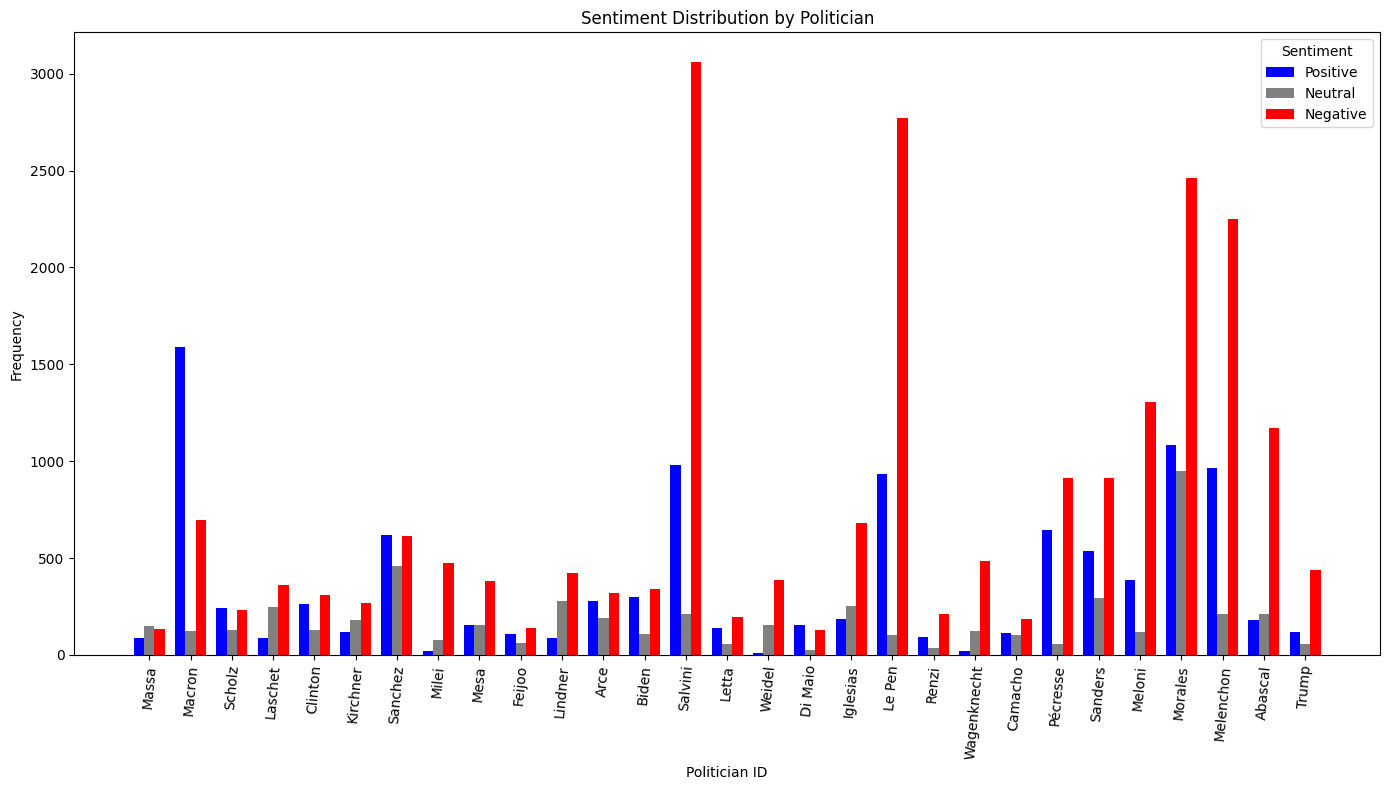

In [70]:

df_predicted_as_one_filtered["Sentiment Label"] = df_predicted_as_one_filtered["Sentiment"].apply(lambda x: x[0])

counts = {label: [] for label in df_predicted_as_one_filtered["Sentiment Label"].unique()}
ids = []

# Count tweets for each sentiment for each ID
for id_ in df_predicted_as_one_filtered["ID"].unique():
    ids.append(id_)  # Add the current ID to the list
    filtered_df = df_predicted_as_one_filtered[df_predicted_as_one_filtered["ID"] == id_]
    sentiment_labels = filtered_df["Sentiment Label"]
    for label in counts.keys():
        counts[label].append((sentiment_labels == label).sum())  # Count occurrences of the label

# Prepare data for plotting
x_positions = np.arange(len(ids))  # Positions for each group of bars
bar_width = 0.25  # Width of each bar

# Define colors and labels for the plot
colors = ["blue", "gray", "red"]
labels = list(counts.keys())

# Set up the bar plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each sentiment category
for i, (label, color) in enumerate(zip(labels, colors)):
    ax.bar(
        x_positions + i * bar_width,  # Offset positions
        counts[label],               # Heights (frequencies)
        width=bar_width,             # Bar width
        color=color,                 # Bar color
        label=label                  # Legend label
    )

# Customize plot
ax.set_xlabel("Politician ID")
ax.set_ylabel("Frequency")
ax.set_title("Sentiment Distribution by Politician")
ax.set_xticks(x_positions + bar_width)  # Align x-axis labels
ax.set_xticklabels(ids, rotation=85)    # Use IDs as x-axis labels
ax.legend(title="Sentiment")            # Add legend

plt.tight_layout()  # Adjust layout
plt.savefig("sentiment_tweets_politicians.pdf", format="pdf", dpi=300)
plt.show()

## Sentiment Analysis x Entities

In [71]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the sentiment model and tokenizer
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    return torch.argmax(probs, dim=1).item()  # 0: Neg, 1: Neu, 2: Pos

# Set window size in words
window_size = 5

sentiment_results = []

for text, entities in zip(
        df_predicted_as_one_filtered['Tweet Text'],
        df_predicted_as_one_filtered['NER_Tags_Cleaned']
    ):

    doc_sentiments = []
    if not isinstance(entities, list):
        sentiment_results.append(doc_sentiments)
        continue

    # Pre-split tweet into words
    tokens = text.split()
    lower_tokens = [t.lower() for t in tokens]

    for entity, label in entities:
        # Split the entity into its component words
        ent_words = entity.split()
        lower_ent = [w.lower() for w in ent_words]

        # Find the first matching span in the token list
        start_idx = -1
        for i in range(len(lower_tokens) - len(lower_ent) + 1):
            if lower_tokens[i:i + len(lower_ent)] == lower_ent:
                start_idx = i
                break
        if start_idx == -1:
            continue

        end_idx = start_idx + len(lower_ent)
        # Compute word-window boundaries
        window_start = max(0, start_idx - window_size)
        window_end   = min(len(tokens), end_idx + window_size)

        window_text = " ".join(tokens[window_start:window_end])
        sentiment = get_sentiment_score(window_text)
        doc_sentiments.append((entity, label, sentiment))

    sentiment_results.append(doc_sentiments)

df_predicted_as_one_filtered["Entity_Sentiments"] = sentiment_results
df_predicted_as_one_filtered.to_csv("sentiment_entity_is.csv", index=False)


/usr/local/jupyterhub/lib64/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
df_predicted_as_one_filtered = pd.read_csv("sentiment_entity_is.csv", encoding="utf-8") ## to comment if the sentiment above gets run
df_predicted_as_one_filtered["Entity_Sentiments"] = df_predicted_as_one_filtered["Entity_Sentiments"].apply(ast.literal_eval) ## as well
# Map sentiment values
def map_sentiment(sentiment):
    return {0: -1, 1: 0, 2: 1}.get(sentiment, 0)  # Default to 0 for unknown values

# Extract relevant information and map sentiment
df_predicted_as_one_filtered["Mapped_Entity_Sentiments"] = df_predicted_as_one_filtered["Entity_Sentiments"].apply(
    lambda entity_list: [(ref, map_sentiment(sent)) for ref, _, sent in entity_list]
)

# Prepare to aggregate results
agg_results = []

# Iterate over each politician's data
for politician_id, group in df_predicted_as_one_filtered.groupby("ID"):
    print(politician_id, group)
    # Flatten the list of (reference, sentiment) for the group
    all_references = [item for sublist in group["Mapped_Entity_Sentiments"] for item in sublist]
    
    # Convert to DataFrame for easier aggregation
    references_df = pd.DataFrame(all_references, columns=["Reference", "Sentiment"])
    
    # Group by reference, calculate total sentiment sum and average
    ref_agg = (
        references_df.groupby("Reference")
        .agg(Total_Sentiment=("Sentiment", "sum"), Count=("Sentiment", "size"))
        .assign(Average_Sentiment=lambda x: x["Total_Sentiment"] / x["Count"])
        .reset_index()
    )
    
    # Add politician ID to the results
    ref_agg["ID"] = politician_id
    agg_results.append(ref_agg)

# Concatenate all results into a single DataFrame
final_agg_df = pd.concat(agg_results, ignore_index=True)

In [163]:
# Create a dictionary mapping of ID to Country
id_to_country = df_predicted_as_one_filtered.set_index('ID')['Country'].to_dict()

# Map the country to the final_agg_df based on the ID column
final_agg_df['Country'] = final_agg_df['ID'].map(id_to_country)

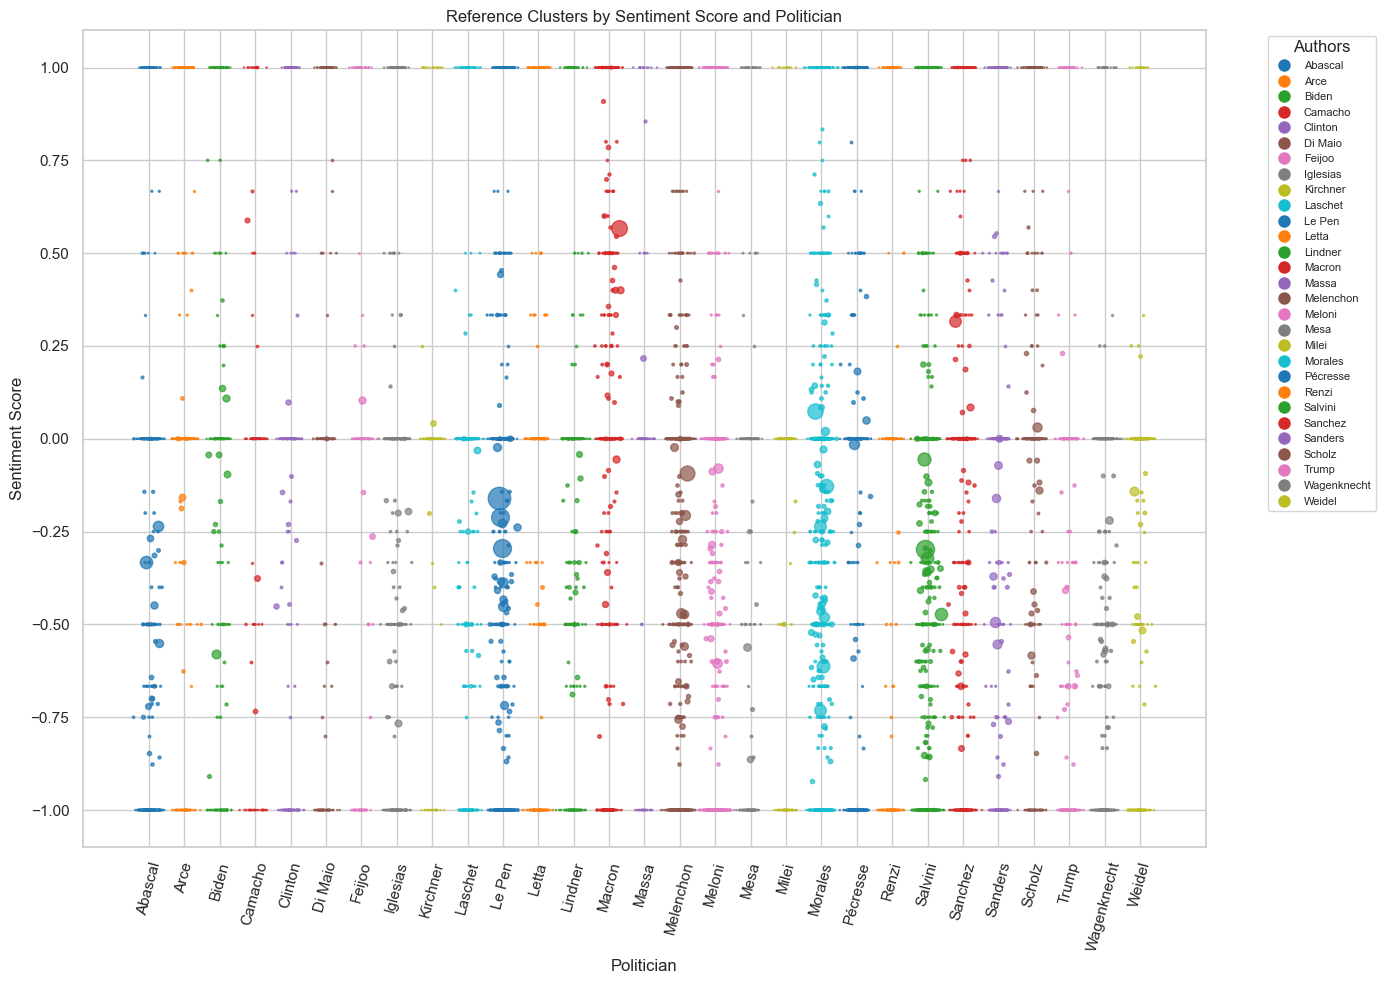

In [188]:
# Extract the list of valid references for labeling from argument_df
valid_references = set()
columns_to_consider = ["Health crisis", "Countries", "Migration", "NGO", "IO", "Europe", "People"]

for column in columns_to_consider:
    valid_references.update(
        ref.strip().lower() for refs in argument_df[column].dropna() for ref in refs
    )

# Filter data to include only specified leaders
leaders = final_agg_df["ID"].unique()  # Get unique politician IDs
filtered_df = final_agg_df[final_agg_df["ID"].isin(leaders)]

# Initialize a list to hold references, sentiment scores, counts, and authors for plotting
plot_data = []
legend_entries = defaultdict(list)

# Extract references, scores, and counts for each politician
for _, row in filtered_df.iterrows():
    author = row["ID"]
    reference = row["Reference"]
    score = row["Average_Sentiment"]
    count = row["Count"]
    plot_data.append((author, reference, score, count))
    legend_entries[(author, score)].append((reference.strip(), count))

# Convert to DataFrame for plotting
plot_df = pd.DataFrame(plot_data, columns=['author', 'reference', 'score', 'count'])

# Set up the main scatter plot
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")

# Assign colors to authors
author_colors = sns.color_palette("tab10", len(leaders))
color_map = dict(zip(leaders, author_colors))

# Initialize a list to hold the text objects for adjust_text
text_objects = []

# Plot each point in the main scatter plot with jitter for readability
for (author, score), subset in plot_df.groupby(['author', 'score']):
    # Apply jitter to x-position to reduce overlap for each author
    x_positions = np.random.normal(loc=list(leaders).index(author), scale=0.15, size=len(subset))
    
    plt.scatter(
        x_positions, [score] * len(subset),
        s=subset['count'] * 0.7,  # Scale size based on total reference count
        color=color_map[author],
        alpha=0.7,
    )
    
    # Label references that are valid and appear more than 50 times
    for x_pos, y_pos, ref, count in zip(x_positions, [score] * len(subset), subset['reference'], subset['count']):
        if ref.strip().lower() in valid_references and count > 50:
            text_objects.append(
                plt.text(x_pos, y_pos, ref, fontsize=9, ha='center')
            )

# Adjust text to avoid overlaps
adjust_text(
    text_objects, 
    arrowprops=dict(arrowstyle="->", color="gray", alpha=0.5, lw=0.5),
    only_move={'points': 'y', 'texts': 'y'},  # Allow vertical adjustment only
    force_text=1.5,
    force_points=0.3
)

# Add the custom legend with fixed-size circles and author colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=author,
                             markerfacecolor=color_map[author], markersize=10)
                  for author in leaders]
plt.legend(handles=legend_handles, title="Authors", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Customize plot
plt.xlabel("Politician")
plt.ylabel("Sentiment Score")
plt.title("Reference Clusters by Sentiment Score and Politician")
plt.xticks(ticks=range(len(leaders)), labels=leaders, rotation=75)
plt.tight_layout()
plt.show()

In [189]:
argument_df = pd.read_csv("country_references.csv", encoding="latin-1")

In [190]:
argument_df.head()

,Health crisis,Countries,Migration,NGO,IO,Europe,People,Country
0,"Covid-19, covid, COVID","Israele, ISR, Ucraina, UKR, Siria, SYR, Palest...","Hamas, Isis, musulmani, Islam, migrante, immig...","Ocean Viking, Sea Watch, Diciotti, Open Arms, ...","Nato, WTO, WHO, ONU, Caritas, Corte penale int...","Europa, europee, consiglio europeo, unione eur...","Orban, Viktor Orban, Bolsonaro, Jair Bolsonaro...",Italy
1,"Covid-19, covid, COVID","Israël, ISR, Ukraine, UKR, Syrie, SYR, Palesti...","Hamas, Isis, musulmans, islam, migrant, immigr...","Ocean Viking, Sea Watch, Diciotti, Open Arms, ...","OTAN, OMC, OMS, ONU, Caritas, Cour pénale inte...","Europe, européennes, Conseil européen, Union e...","Orban, Viktor Orban, Bolsonaro, Jair Bolsonaro...",France
2,"Covid-19, covid, COVID","Israel, ISR, Ukraine, UKR, Syria, SYR, Palesti...","Hamas, ISIS, Muslims, Islam, migrant, immigran...","Ocean Viking, Sea Watch, Diciotti, Open Arms, ...","NATO, WTO, WHO, UN, Caritas, International Cri...","Europe, European, European Council, European U...","Orban, Viktor Orban, Bolsonaro, Jair Bolsonaro...",USA
3,"Covid-19, covid, COVID","Israel, ISR, Ukraine, UKR, Syrien, SYR, Paläst...","Hamas, ISIS, Muslime, Islam, Migrant, Einwande...","Ocean Viking, Sea Watch, Diciotti, Open Arms, ...","NATO, WTO, WHO, UN, Caritas, Internationaler S...","Europa, europäische, Europäischer Rat, Europäi...","Orban, Viktor Orban, Bolsonaro, Jair Bolsonaro...",Germany
4,"Covid-19, covid, COVID","Israel, ISR, Ucrania, UKR, Siria, SYR, Palesti...","Hamas, ISIS, musulmanes, islam, migrante, inmi...","Ocean Viking, Sea Watch, Diciotti, Open Arms, ...","OTAN, OMC, OMS, ONU, Caritas, Corte Penal Inte...","Europa, europeas, Consejo Europeo, Unión Europ...","Orban, Viktor Orban, Bolsonaro, Jair Bolsonaro...",Spain


In [191]:
filtered_df

,Reference,Total_Sentiment,Count,Average_Sentiment,ID,Country
0,#6d,-1,1,-1.0,Abascal,Spain
1,#alfieevans,-1,1,-1.0,Abascal,Spain
2,#alfieevans.,-1,1,-1.0,Abascal,Spain
3,#almería,-1,1,-1.0,Abascal,Spain
4,#aquarius,0,1,0.0,Abascal,Spain
...,...,...,...,...,...,...
15220,🇩🇪?++,-1,1,-1.0,Weidel,Germany
15221,🇫🇷,1,1,1.0,Weidel,Germany
15222,🇭🇺,0,1,0.0,Weidel,Germany
15223,🇮🇱,0,1,0.0,Weidel,Germany


In [193]:
Counter(filtered_df["Category"])

Counter({None: 12745,
         'NGO': 48,
         'Countries': 1418,
         'People': 334,
         'Europe': 275,
         'Migration': 143,
         'Health crisis': 69,
         'IO': 193})

In [194]:
set(filtered_df["ID"])

{'Abascal',
 'Arce',
 'Biden',
 'Camacho',
 'Clinton',
 'Di Maio',
 'Feijoo',
 'Iglesias',
 'Kirchner',
 'Laschet',
 'Le Pen',
 'Letta',
 'Lindner',
 'Macron',
 'Massa',
 'Melenchon',
 'Meloni',
 'Mesa',
 'Milei',
 'Morales',
 'Pécresse',
 'Renzi',
 'Salvini',
 'Sanchez',
 'Sanders',
 'Scholz',
 'Trump',
 'Wagenknecht',
 'Weidel'}

In [199]:
# Calculate average sentiment score per Politician_ID
average_sentiment_per_politician = final_agg_df.groupby('ID').apply(
    lambda x: (x['Average_Sentiment'] * x['Count']).sum() / x['Count'].sum() if x['Count'].sum() > 0 else 0
).reset_index(name='average_sentiment')

# Display the resulting average sentiment per politician
print(average_sentiment_per_politician)


             ID  average_sentiment
0       Abascal          -0.394223
1          Arce          -0.017241
2         Biden          -0.159935
3       Camacho          -0.109005
4       Clinton          -0.130734
5       Di Maio          -0.106383
6        Feijoo          -0.158301
7      Iglesias          -0.280172
8      Kirchner          -0.054422
9       Laschet          -0.225573
10       Le Pen          -0.312615
11        Letta          -0.214612
12      Lindner          -0.223226
13       Macron           0.179601
14        Massa          -0.022556
15    Melenchon          -0.281800
16       Meloni          -0.356383
17         Mesa          -0.414322
18        Milei          -0.324176
19      Morales          -0.233623
20     Pécresse          -0.154692
21        Renzi          -0.306452
22      Salvini          -0.331475
23      Sanchez          -0.108917
24      Sanders          -0.265925
25       Scholz          -0.078007
26        Trump          -0.417544
27  Wagenknecht     

In [200]:
filtered_df

,Reference,Total_Sentiment,Count,Average_Sentiment,ID,Country,Category
0,#6d,-1,1,-1.0,Abascal,Spain,None
1,#alfieevans,-1,1,-1.0,Abascal,Spain,None
2,#alfieevans.,-1,1,-1.0,Abascal,Spain,None
3,#almería,-1,1,-1.0,Abascal,Spain,None
4,#aquarius,0,1,0.0,Abascal,Spain,None
...,...,...,...,...,...,...,...
15220,🇩🇪?++,-1,1,-1.0,Weidel,Germany,None
15221,🇫🇷,1,1,1.0,Weidel,Germany,None
15222,🇭🇺,0,1,0.0,Weidel,Germany,None
15223,🇮🇱,0,1,0.0,Weidel,Germany,None


In [201]:
# Filter out rows where Category is None
filtered_df = filtered_df[
    filtered_df['Category'].notna() &
    (filtered_df['Count'] >= 2)
]


In [226]:
# 1) Categories
categories = ['Health crisis', 'Countries', 'Migration', 'NGO', 'IO', 'Europe', 'People']

# 2) Build mappings from term → category
raw_to_cat = {}   # for raw, single‐token matches
norm_to_cat = {}  # for hashtag‐based matches
for cat in categories:
    terms = (
        argument_df[cat]
        .str.split(',').explode()
        .str.strip().dropna()
        .unique()
    )
    for term in terms:
        term_low = term.lower()
        # prepare raw only for single‐token seeds
        if ' ' not in term:
            raw_to_cat[term] = cat
        # prepare normalized for ALL seeds (to catch hashtags of multi‐word seeds too)
        norm = re.sub(r'\W+', '', term_low)
        norm_to_cat[norm] = cat

# 3) Updated extraction: raw token matches OR hashtag matches only
def extract_references(text):
    # 1) Work on the original text for raw matches
    text_raw  = text

    # 2) Prepare a “normalized” version only for tag matching
    text_norm = re.sub(r'\W+', '', text)

    matches, seen = [], set()

    # 3a) Tag‐based matching (normalized): hashtags AND mentions
    #    We capture the part after # or @, normalize it, and lookup
    for tag in re.findall(r'[@#](\w+)', text):
        norm_tag = re.sub(r'\W+', '', tag)
        if norm_tag in norm_to_cat and norm_tag not in seen:
            matches.append((f'#{tag}', norm_to_cat[norm_tag]))
            seen.add(norm_tag)

    # 3b) Raw, single‐token word‐boundary matching (case‐sensitive)
    for seed, cat in raw_to_cat.items():
        if re.search(rf'\b{re.escape(seed)}\b', text_raw) and seed not in seen:
            matches.append((seed, cat))
            seen.add(seed)

    return matches

# 4) Apply extraction
df = df_predicted_as_one_filtered.copy()
df['Extracted'] = df['Tweet Text'].apply(extract_references)

# 5) Explode & split
df = df.explode('Extracted').dropna(subset=['Extracted'])
df[['Reference', 'Category']] = pd.DataFrame(df['Extracted'].tolist(), index=df.index)
df.drop(columns=['Extracted'], inplace=True)

# 6) Map sentiment to numeric
label_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
df['Sentiment_Score'] = df['Sentiment Label'].map(label_map)

# 7) Aggregate
filtered_df = (
    df
    .groupby(['Category','ID','Country'], as_index=False)
    .agg(
        Total_Sentiment=('Sentiment_Score','sum'),
        Count=('Sentiment_Score','count')
    )
)
filtered_df['Average_Sentiment'] = filtered_df['Total_Sentiment'] / filtered_df['Count']

# 8) Final average_sentiments
average_sentiments = (
    filtered_df
    .groupby(['Category','ID','Country'], as_index=False)
    .agg(
        Average_Sentiment=('Average_Sentiment','mean'),
        Total_References=('Count','sum')
    )
)

In [234]:
# Build a dict mapping each category to a Counter of its References
category_counters = {
    category: Counter(group['Reference'])
    for category, group in df.groupby('Category')
}

# Print them out
for category, counter in category_counters.items():
    print(f"{category}: {counter}")

Countries: Counter({'France': 1687, 'Bolivia': 1262, 'Italia': 1199, 'Ukraine': 887, 'España': 722, 'Israel': 384, 'Venezuela': 368, 'Deutschland': 288, 'Argentina': 213, 'Chile': 211, 'Russie': 200, 'Cuba': 189, 'USA': 185, 'Russland': 175, 'Ucrania': 172, 'Syrie': 170, 'Francia': 162, 'Russia': 157, 'Iran': 155, 'Afghanistan': 151, 'Irak': 129, 'China': 122, 'Libia': 120, 'Siria': 115, 'Palestina': 110, 'Israël': 108, 'Rusia': 108, 'Ucraina': 105, 'Türkei': 96, 'Colombia': 94, 'Africa': 91, 'Syrien': 88, 'Perú': 86, 'México': 82, 'Allemagne': 79, 'Iraq': 76, 'Afrique': 69, 'Turchia': 68, 'Turquie': 67, 'Nicaragua': 67, 'Ecuador': 65, 'Israele': 63, 'Libye': 62, 'Germania': 61, 'Brasil': 58, 'Liban': 58, 'Grèce': 56, 'Algérie': 56, 'Irán': 50, 'Palestine': 50, 'Italie': 50, 'Syria': 49, 'Grecia': 45, 'Qatar': 44, 'Yemen': 43, 'Germany': 41, 'Frankreich': 40, 'Pologne': 38, 'Chine': 37, 'India': 37, 'Spain': 37, 'Alemania': 37, 'Afganistán': 35, 'Cina': 34, 'Spagna': 34, 'Tunisie': 31,

In [235]:
filtered_df = filtered_df.merge(
    metadata_df[['ID', 'Populist', 'orientation']],
    on='ID',
    how='left'
)

# (Optional) sanity‑check
missing = filtered_df.loc[filtered_df['Populist'].isna(), 'ID'].unique()
if len(missing) > 0:
    print("Warning: these IDs have no metadata:", missing)

# 2) Compute average sentiment per Category/ID including new columns
average_sentiments = (
    filtered_df
    .groupby(["Category", "ID", "Country", "Populist", "orientation"])
    .agg(
        Average_Sentiment=("Average_Sentiment", "mean"),
        Total_References=("Count", "sum")
    )
    .reset_index()
)

# Prepare category‑to‑x mapping for jitter
categories = average_sentiments["Category"].unique()
category_mapping = {cat: i for i, cat in enumerate(categories)}

Saved plot to average_sentiment_by_orientation.jpg


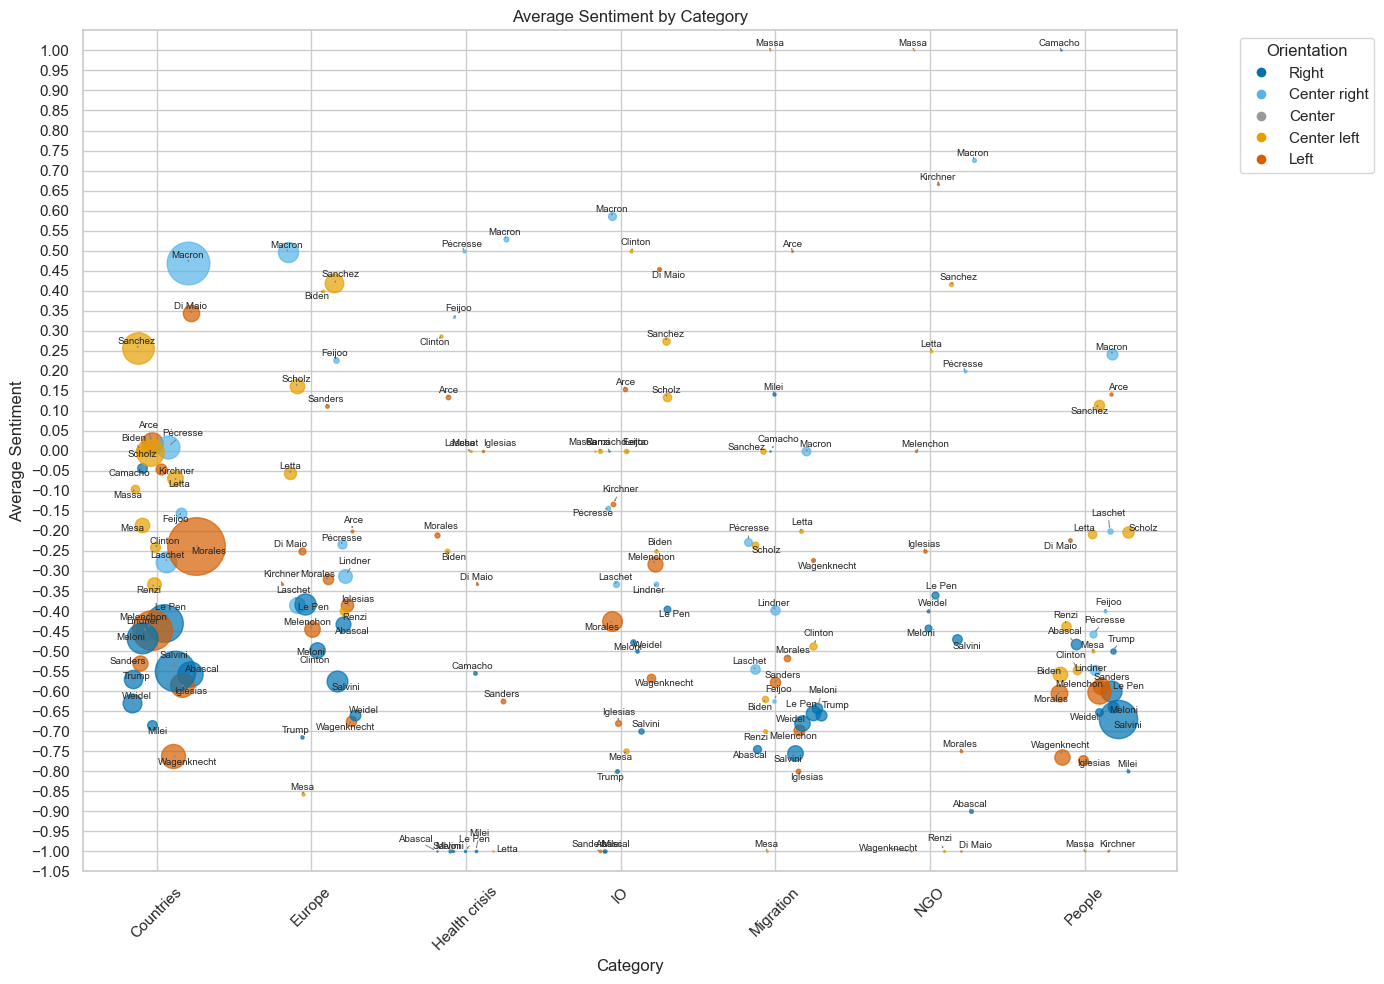

In [276]:
# Helper to draw one scatter colored by a given flag, save it, then show it
def plot_and_save(flag_col, color_map, legend_title, filename):
    plt.figure(figsize=(14, 10))
    texts = []
    
    for _, row in average_sentiments.iterrows():
        x = category_mapping[row["Category"]] + np.random.uniform(-0.2, 0.3)
        c = color_map[row[flag_col]]
        plt.scatter(
            x, row["Average_Sentiment"],
            s=row["Total_References"] * 0.7,
            color=c, alpha=0.7
        )
        texts.append(plt.text(
            x, row["Average_Sentiment"],
            row["ID"], fontsize=7, ha="center"
        ))
    
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.7))
    plt.ylim(-1.05, 1.05)
    plt.yticks(np.arange(-1.05, 1.05, 0.05))
    plt.xticks(ticks=range(len(categories)), labels=categories, rotation=45)
    plt.xlabel("Category")
    plt.ylabel("Average Sentiment")
    plt.title(f"Average Sentiment by Category")
    
    handles = [
        Line2D([0], [0], marker='o', color='w', label=str(flag),
               markersize=8, markerfacecolor=color_map[flag])
        for flag in color_map
    ]
    plt.legend(handles=handles, title=legend_title,
               bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    
    # save as PDF
    plt.savefig(filename, format='jpg', dpi=300, bbox_inches='tight')
    print(f"Saved plot to {filename}")
    
    # show interactively if desired
    plt.show()

orientation_color_map = {
    "Right":        "#0072B2",  # blue
    "Center right": "#56B4E9",  # sky-blue
    "Center":       "#999999",  # grey
    "Center left":  "#E69F00",  # orange
    "Left":         "#D55E00"   # vermillion
}
plot_and_save(
    flag_col="orientation",
    color_map=orientation_color_map,
    legend_title="Orientation",
    filename="average_sentiment_by_orientation.jpg"
)

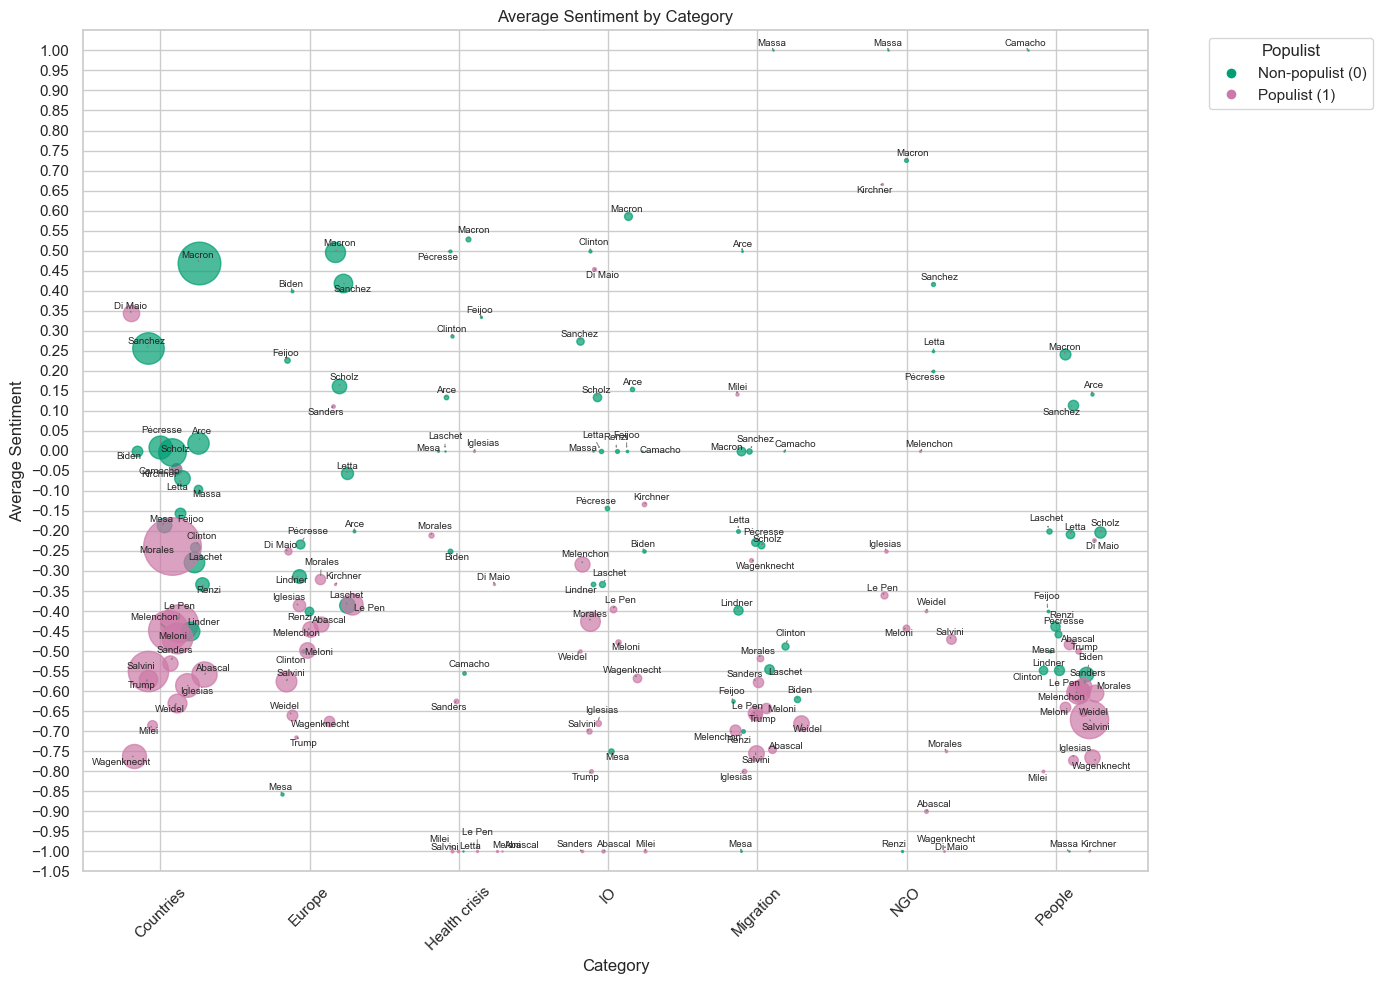

In [275]:
# 3a) Plot & save by populism: non-populist blue, populist red
populist_color_map = {
    0: "#009E73",  # bluish-green (non-populist)
    1: "#CC79A7"   # reddish-purple (populist)
}
populist_label_map = {
    0: "Non-populist (0)",
    1: "Populist (1)"
}

plt.figure(figsize=(14, 10))
texts = []
for _, row in average_sentiments.iterrows():
    x = category_mapping[row["Category"]] + np.random.uniform(-0.2, 0.3)
    c = populist_color_map[row["Populist"]]
    plt.scatter(x, row["Average_Sentiment"],
                s=row["Total_References"] * 0.7,
                color=c, alpha=0.7)
    texts.append(plt.text(x, row["Average_Sentiment"],
                          row["ID"], fontsize=7, ha="center"))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.7))

plt.ylim(-1.05, 1.05)
plt.yticks(np.arange(-1.05, 1.05, 0.05))
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=45)
plt.xlabel("Category")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment by Category")

# build handles with custom labels
handles = [
    Line2D([0], [0], marker='o', color='w',
           label=populist_label_map[flag],
           markersize=8,
           markerfacecolor=populist_color_map[flag])
    for flag in populist_color_map
]
plt.legend(handles=handles, title="Populist",
           bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("average_sentiment_by_populism.jpg", format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [241]:
agg_df = (
    df
    .groupby(['Country', 'ID', 'Reference'], as_index=False)
    .agg(
        Total_References = ('Reference', 'count'),
        Average_Sentiment = ('Sentiment_Score', 'mean')
    )
)

In [249]:
# create output dir
output_directory = "country_sentiment_plots"
os.makedirs(output_directory, exist_ok=True)

# prepare colors
unique_countries = agg_df["Country"].dropna().unique()
country_colors = sns.color_palette("colorblind", len(unique_countries))
country_color_map = dict(zip(unique_countries, country_colors))

# (re)build your set of references you want to label…
references_to_label = set()
for col in argument_df.columns:
    if col != "Country":
        for refs in argument_df[col].dropna():
            for ref in refs.split(","):
                references_to_label.add(ref.strip().lower())

# now loop…
for country in unique_countries:
    country_data = agg_df[agg_df["Country"] == country]

    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid")
    texts = []

    authors = country_data["ID"].unique().tolist()
    for _, r in country_data.iterrows():
        x = authors.index(r["ID"]) + np.random.uniform(-0.2, 0.2)
        plt.scatter(
            x,
            r["Average_Sentiment"],
            s=r["Total_References"] * 5,
            c=[country_color_map[country]],
            alpha=0.7
        )
        # annotate if in your seed list or super-frequent
        if (r["Total_References"] > 10):
            texts.append(plt.text(
                x, r["Average_Sentiment"], r["Reference"],
                ha="center", fontsize=12
            ))

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))
    plt.xticks(ticks=range(len(authors)), labels=authors, rotation=45)
    plt.ylim(-1.2, 1.2)
    plt.xlabel("Politician ID")
    plt.ylabel("Average Sentiment")
    plt.title(f"Reference Sentiment by ID for {country}")

    handle = plt.Line2D(
        [0], [0], marker="o", color="w", label=country,
        markersize=8, markerfacecolor=country_color_map[country]
    )
    plt.legend(handles=[handle], title="Country",
               loc="upper left", bbox_to_anchor=(1.05, 1))

    out_path = os.path.join(
        output_directory,
        f"{country}_sentiment_id_plot.pdf"
    )
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"→ Saved plot for {country}: {out_path}")

→ Saved plot for Argentina: country_sentiment_plots/Argentina_sentiment_id_plot.pdf
→ Saved plot for Bolivia: country_sentiment_plots/Bolivia_sentiment_id_plot.pdf
→ Saved plot for France: country_sentiment_plots/France_sentiment_id_plot.pdf
→ Saved plot for Germany: country_sentiment_plots/Germany_sentiment_id_plot.pdf
→ Saved plot for Italy: country_sentiment_plots/Italy_sentiment_id_plot.pdf
→ Saved plot for Spain: country_sentiment_plots/Spain_sentiment_id_plot.pdf
→ Saved plot for USA: country_sentiment_plots/USA_sentiment_id_plot.pdf


In [250]:
output_directory = "politician_plots"
os.makedirs(output_directory, exist_ok=True)

# 2) (Re)use your country→color map
unique_countries = agg_df["Country"].dropna().unique()
country_colors = sns.color_palette("colorblind", len(unique_countries))
country_color_map = dict(zip(unique_countries, country_colors))

# 3) Loop over each politician
for politician in agg_df["ID"].unique():
    pol_df = agg_df[agg_df["ID"] == politician]
    if pol_df.empty:
        continue

    # figure & theme
    plt.figure(figsize=(14, 10))
    sns.set_theme(style="whitegrid")
    texts = []

    # get the one country color for this politician
    country = pol_df["Country"].iloc[0]
    color = country_color_map.get(country, "gray")

    # x positions = one per unique reference
    refs = pol_df["Reference"].tolist()
    unique_refs = list(dict.fromkeys(refs))  # preserves order
    for _, row in pol_df.iterrows():
        idx = unique_refs.index(row["Reference"])
        x = idx + np.random.uniform(-0.2, 0.2)
        plt.scatter(
            x,
            row["Average_Sentiment"],
            s=row["Total_References"] * 5,
            c=[color],
            alpha=0.7
        )
        # only label if count > 50
        if row["Total_References"] > 10:
            texts.append(plt.text(
                x,
                row["Average_Sentiment"],
                row["Reference"],
                ha="center",
                fontsize=12
            ))

    # adjust overlapping text
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

    # axes & title
    plt.xticks(ticks=range(len(unique_refs)), labels=unique_refs, rotation=45, ha="right")
    plt.ylim(-1.2, 1.2)
    plt.xlabel("Reference")
    plt.ylabel("Average Sentiment")
    plt.title(f"Reference Sentiment for {politician}")

    # legend showing country color
    handle = Line2D([0], [0],
                    marker="o", color="w",
                    label=country,
                    markersize=8,
                    markerfacecolor=color)
    plt.legend(handles=[handle],
               title="Country",
               loc="upper left",
               bbox_to_anchor=(1.05, 1))

    # save & close
    out_path = os.path.join(output_directory, f"{politician}_sentiment_plot.pdf")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"→ Saved plot for {politician}: {out_path}")

→ Saved plot for Kirchner: politician_plots/Kirchner_sentiment_plot.pdf
→ Saved plot for Massa: politician_plots/Massa_sentiment_plot.pdf
→ Saved plot for Milei: politician_plots/Milei_sentiment_plot.pdf
→ Saved plot for Arce: politician_plots/Arce_sentiment_plot.pdf
→ Saved plot for Camacho: politician_plots/Camacho_sentiment_plot.pdf
→ Saved plot for Mesa: politician_plots/Mesa_sentiment_plot.pdf
→ Saved plot for Morales: politician_plots/Morales_sentiment_plot.pdf
→ Saved plot for Le Pen: politician_plots/Le Pen_sentiment_plot.pdf
→ Saved plot for Macron: politician_plots/Macron_sentiment_plot.pdf
→ Saved plot for Melenchon: politician_plots/Melenchon_sentiment_plot.pdf
→ Saved plot for Pécresse: politician_plots/Pécresse_sentiment_plot.pdf
→ Saved plot for Laschet: politician_plots/Laschet_sentiment_plot.pdf
→ Saved plot for Lindner: politician_plots/Lindner_sentiment_plot.pdf
→ Saved plot for Scholz: politician_plots/Scholz_sentiment_plot.pdf
→ Saved plot for Wagenknecht: politici

In [ ]:

# Define filtering criteria
criteria = [
    {"Populist": 1, "government": 0, "orientation": "Right", "rec/don": 0},
    {"Populist": 0, "government": 0, "orientation": "Left", "rec/don": 0},
    {"Populist": 1, "government": 1, "orientation": "Right", "rec/don": 0},
    {"Populist": 0, "government": 1, "orientation": "Left", "rec/don": 0},
    {"Populist": 1, "government": 0, "orientation": "Right", "rec/don": 1},
    {"Populist": 1, "government": 1, "orientation": "Left", "rec/don": 0},
]

# Prepare a list to collect rows for the final DataFrame
rows = []

# Iterate over criteria and collect matching tweets with author names
for i, crit in enumerate(criteria, start=1):
    # Filter tweets based on the current criteria
    filtered_tweets = df_predicted_as_one_filtered[
        (df_predicted_as_one_filtered["Populist"] == crit["Populist"]) &
        (df_predicted_as_one_filtered["government"] == crit["government"]) &
        (df_predicted_as_one_filtered["orientation"] == crit["orientation"]) &
        (df_predicted_as_one_filtered["rec/don"] == crit["rec/don"])
    ][["Tweet Text", "ID"]]

    # Limit to 2 tweets per ID and 10 total examples
    tweets_per_id = filtered_tweets.groupby("ID").head(2)  # Take 2 tweets per ID
    final_tweets = tweets_per_id.head(10)  # Limit to a maximum of 10 tweets

    # Add criteria as a string and collect rows
    for _, row in final_tweets.iterrows():
        rows.append({
            "Criteria": f"Criteria {i}: {crit}",
            "ID": row["ID"],
            "Tweet Text": row["Tweet Text"]
        })

# Convert collected rows to a DataFrame
output_df = pd.DataFrame(rows)

# Save to CSV
output_file = "filtered_tweets_by_criteria.csv"
output_df.to_csv(output_file, index=False)

In [ ]:
# Define the keywords for each criterion
keywords1 = ["NATO", "OTAN"]
keywords2 = ["oceanviking", "WTO", "WHO"]

# Function to filter tweets based on keywords and save results
def filter_and_save_tweets(keywords, criteria_name, output_file):
    # Filter for Populist = 1 and keywords in the tweet
    filtered_tweets = df_predicted_as_one_filtered[
        (df_predicted_as_one_filtered["Populist"] == 1) &
        (df_predicted_as_one_filtered["Tweet Text"].str.contains('|'.join(keywords), case=False, na=False))
    ][["Tweet Text", "ID"]]

    # Limit to 2 tweets per ID and 10 total examples
    tweets_per_id = filtered_tweets.groupby("ID").head(2)  # Take 2 tweets per ID
    final_tweets = tweets_per_id.head(10)  # Limit to a maximum of 10 tweets

    # Prepare the output DataFrame
    output_df = final_tweets.copy()
    output_df["Criteria"] = criteria_name

    # Save to CSV
    output_df.to_csv(output_file, index=False)
    
# Apply the filtering and saving for each criteria
filter_and_save_tweets(keywords1, "Populist = 1, contains NATO/OTAN", "filtered_populist_tweets_nato.csv")
filter_and_save_tweets(keywords2, "Populist = 1, contains oceanviking/WTO/WHO", "filtered_populist_tweets_oceanviking.csv")

In [92]:
df_cleaned.to_csv("df_allweightedvariables.csv", encoding="UTF-8", index=False)